<a href="https://colab.research.google.com/github/dmalya96/GAN/blob/main/Vanilla_GAN_Cifar10_IGMD_Layers_Deer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Vanilla GAN on Cifar 10 (Deer Images)

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from matplotlib import pyplot

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
  model = tf.keras.Sequential()
  # foundation for 4x4 image
  model.add(layers.Dense(4*4*512, use_bias=False, input_dim=latent_dim))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Reshape((4, 4, 512)))
  # upsample to 8x8
  model.add(layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # upsample to 16x16
  model.add(layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # upsample to 32x32
  model.add(layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # output layer
  model.add(layers.Conv2D(3, (5,5), activation='tanh', padding='same'))
  return model

In [ ]:
# define the standalone discriminator model
def define_discriminator():
  model = tf.keras.Sequential()
  # normal
  model.add(layers.Conv2D(96, (3,3), padding='same', input_shape=[32, 32, 3]))
  model.add(layers.LeakyReLU(alpha=0.2))
  # downsample
  model.add(layers.Conv2D(96, (3,3), strides=1, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(96, (3,3), strides=2, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.5))
  # downsample
  model.add(layers.Conv2D(192, (3,3), strides=1, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(192, (3,3), strides=1, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(192, (3,3), strides=2, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.5))
  # downsample
  model.add(layers.Conv2D(192, (3,3), strides=2, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # downsample
  model.add(layers.Conv2D(192, (3,3), strides=2, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # classifier
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = tf.keras.Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
# load and prepare cifar10 training images
def load_real_samples():
  # load cifar10 dataset
  (trainX, trainY), (_, _) = tf.keras.datasets.cifar10.load_data()
  # Select deer images (Class 4)
  trainX = trainX[trainY.flatten() == 4]
  # convert from unsigned ints to floats
  X = trainX.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=5):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png'
	pyplot.savefig(filename)
	pyplot.close()

In [ ]:
# evaluate the discriminator, plot generated images, save generator model

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# generate images
	latent_points = generate_latent_points(100, 100)
	X = g_model.predict(latent_points)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot the result
	create_plot(X, 5)

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=300, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 5 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

170500096/170498071 [==============================] - 3s 0us/step
>1, 1/39, d1=0.699, d2=0.696 g=0.692
>1, 2/39, d1=0.674, d2=0.696 g=0.692
>1, 3/39, d1=0.619, d2=0.704 g=0.687
>1, 4/39, d1=0.457, d2=0.782 g=0.645
>1, 5/39, d1=0.173, d2=1.100 g=0.618
>1, 6/39, d1=0.129, d2=0.974 g=0.673
>1, 7/39, d1=0.199, d2=0.830 g=0.700
>1, 8/39, d1=0.198, d2=0.726 g=0.734
>1, 9/39, d1=0.104, d2=0.818 g=0.815
>1, 10/39, d1=0.106, d2=0.659 g=0.968
>1, 11/39, d1=0.103, d2=2.709 g=1.055
>1, 12/39, d1=0.365, d2=0.536 g=1.083
>1, 13/39, d1=0.516, d2=0.564 g=0.917
>1, 14/39, d1=0.407, d2=0.635 g=0.771
>1, 15/39, d1=0.289, d2=0.719 g=0.705
>1, 16/39, d1=0.198, d2=1.074 g=0.600
>1, 17/39, d1=0.183, d2=1.481 g=0.616
>1, 18/39, d1=0.317, d2=0.865 g=0.738
>1, 19/39, d1=0.431, d2=0.636 g=0.919
>1, 20/39, d1=0.398, d2=0.530 g=1.196
>1, 21/39, d1=0.254, d2=0.427 g=1.581
>1, 22/39, d1=0.326, d2=0.586 g=1.050
>1, 23/39, d1=0.166, d2=0.749 g=0.844
>1, 24/39, d1=0.054, d2=0.677 g=0.814
>1, 25/39, d1=0.063, d2=0.714 

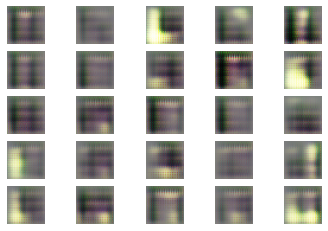

>6, 1/39, d1=0.459, d2=0.541 g=1.479
>6, 2/39, d1=0.683, d2=0.772 g=1.233
>6, 3/39, d1=0.720, d2=0.802 g=1.189
>6, 4/39, d1=0.825, d2=0.447 g=1.233
>6, 5/39, d1=0.614, d2=0.460 g=1.475
>6, 6/39, d1=0.579, d2=0.403 g=1.474
>6, 7/39, d1=0.561, d2=0.465 g=1.516
>6, 8/39, d1=0.474, d2=0.420 g=1.395
>6, 9/39, d1=0.567, d2=0.386 g=1.386
>6, 10/39, d1=0.623, d2=0.408 g=1.364
>6, 11/39, d1=0.643, d2=0.508 g=1.213
>6, 12/39, d1=0.458, d2=0.465 g=1.166
>6, 13/39, d1=0.439, d2=0.512 g=1.036
>6, 14/39, d1=0.424, d2=0.689 g=1.025
>6, 15/39, d1=0.425, d2=0.702 g=1.006
>6, 16/39, d1=0.502, d2=0.627 g=1.061
>6, 17/39, d1=0.559, d2=0.563 g=1.112
>6, 18/39, d1=0.564, d2=0.553 g=1.100
>6, 19/39, d1=0.611, d2=0.548 g=1.088
>6, 20/39, d1=0.585, d2=0.664 g=1.043
>6, 21/39, d1=0.528, d2=0.549 g=1.091
>6, 22/39, d1=0.477, d2=0.587 g=1.186
>6, 23/39, d1=0.630, d2=0.512 g=1.104
>6, 24/39, d1=0.526, d2=0.631 g=1.143
>6, 25/39, d1=0.603, d2=0.665 g=1.093
>6, 26/39, d1=0.591, d2=0.647 g=1.067
>6, 27/39, d1=0.605, 

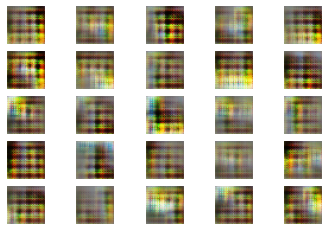

>11, 1/39, d1=0.410, d2=0.418 g=1.497
>11, 2/39, d1=0.466, d2=0.463 g=1.547
>11, 3/39, d1=0.312, d2=0.559 g=1.565
>11, 4/39, d1=0.452, d2=0.617 g=1.407
>11, 5/39, d1=0.636, d2=0.665 g=1.384
>11, 6/39, d1=0.643, d2=0.534 g=1.354
>11, 7/39, d1=0.533, d2=0.528 g=1.296
>11, 8/39, d1=0.589, d2=0.509 g=1.244
>11, 9/39, d1=0.616, d2=0.554 g=1.208
>11, 10/39, d1=0.597, d2=0.602 g=1.180
>11, 11/39, d1=0.600, d2=0.549 g=1.302
>11, 12/39, d1=0.652, d2=0.447 g=1.267
>11, 13/39, d1=0.705, d2=0.524 g=1.209
>11, 14/39, d1=0.553, d2=0.591 g=1.219
>11, 15/39, d1=0.569, d2=0.481 g=1.367
>11, 16/39, d1=0.565, d2=0.548 g=1.380
>11, 17/39, d1=0.584, d2=0.418 g=1.512
>11, 18/39, d1=0.489, d2=0.421 g=1.539
>11, 19/39, d1=0.541, d2=0.443 g=1.453
>11, 20/39, d1=0.506, d2=0.575 g=1.261
>11, 21/39, d1=0.606, d2=0.600 g=1.098
>11, 22/39, d1=0.496, d2=0.673 g=1.200
>11, 23/39, d1=0.515, d2=0.497 g=1.272
>11, 24/39, d1=0.451, d2=0.552 g=1.380
>11, 25/39, d1=0.506, d2=0.504 g=1.600
>11, 26/39, d1=0.712, d2=0.385 g=1

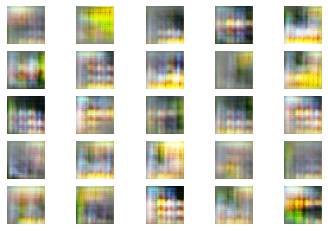

>16, 1/39, d1=0.609, d2=0.572 g=1.612
>16, 2/39, d1=0.839, d2=0.523 g=1.517
>16, 3/39, d1=0.704, d2=0.466 g=1.374
>16, 4/39, d1=0.638, d2=0.517 g=1.405
>16, 5/39, d1=0.535, d2=0.399 g=1.538
>16, 6/39, d1=0.580, d2=0.497 g=1.421
>16, 7/39, d1=0.504, d2=0.535 g=1.607
>16, 8/39, d1=0.512, d2=0.550 g=1.856
>16, 9/39, d1=0.547, d2=0.357 g=1.807
>16, 10/39, d1=0.527, d2=0.471 g=2.011
>16, 11/39, d1=0.690, d2=0.416 g=1.756
>16, 12/39, d1=0.530, d2=0.544 g=1.552
>16, 13/39, d1=0.477, d2=0.543 g=1.438
>16, 14/39, d1=0.631, d2=0.714 g=1.579
>16, 15/39, d1=0.631, d2=0.388 g=1.659
>16, 16/39, d1=0.643, d2=0.419 g=1.654
>16, 17/39, d1=0.483, d2=0.509 g=1.545
>16, 18/39, d1=0.368, d2=0.690 g=1.589
>16, 19/39, d1=0.642, d2=0.648 g=1.294
>16, 20/39, d1=0.616, d2=0.652 g=1.024
>16, 21/39, d1=0.679, d2=0.700 g=1.022
>16, 22/39, d1=0.608, d2=0.645 g=1.067
>16, 23/39, d1=0.742, d2=0.576 g=1.144
>16, 24/39, d1=0.644, d2=0.473 g=1.200
>16, 25/39, d1=0.584, d2=0.587 g=1.194
>16, 26/39, d1=0.521, d2=0.535 g=1

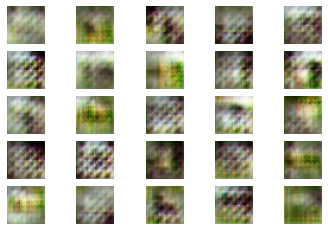

>21, 1/39, d1=0.560, d2=0.563 g=1.098
>21, 2/39, d1=0.606, d2=0.578 g=1.121
>21, 3/39, d1=0.654, d2=0.603 g=1.097
>21, 4/39, d1=0.624, d2=0.568 g=1.047
>21, 5/39, d1=0.616, d2=0.569 g=1.103
>21, 6/39, d1=0.459, d2=0.591 g=1.108
>21, 7/39, d1=0.547, d2=0.615 g=1.153
>21, 8/39, d1=0.488, d2=0.626 g=1.081
>21, 9/39, d1=0.557, d2=0.733 g=1.012
>21, 10/39, d1=0.477, d2=0.632 g=1.055
>21, 11/39, d1=0.492, d2=0.611 g=1.157
>21, 12/39, d1=0.470, d2=0.590 g=1.235
>21, 13/39, d1=0.541, d2=0.488 g=1.309
>21, 14/39, d1=0.532, d2=0.511 g=1.361
>21, 15/39, d1=0.475, d2=0.449 g=1.473
>21, 16/39, d1=0.479, d2=0.484 g=1.483
>21, 17/39, d1=0.447, d2=0.481 g=1.596
>21, 18/39, d1=0.423, d2=0.433 g=1.825
>21, 19/39, d1=0.571, d2=0.351 g=1.682
>21, 20/39, d1=0.500, d2=0.494 g=1.515
>21, 21/39, d1=0.551, d2=0.572 g=1.496
>21, 22/39, d1=0.488, d2=0.547 g=1.380
>21, 23/39, d1=0.545, d2=0.629 g=1.428
>21, 24/39, d1=0.616, d2=0.496 g=1.350
>21, 25/39, d1=0.514, d2=0.567 g=1.459
>21, 26/39, d1=0.413, d2=0.614 g=1

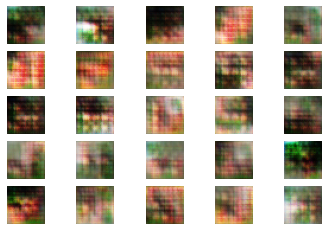

>26, 1/39, d1=0.531, d2=0.488 g=1.512
>26, 2/39, d1=0.615, d2=0.505 g=1.388
>26, 3/39, d1=0.637, d2=0.695 g=1.362
>26, 4/39, d1=0.574, d2=0.599 g=1.331
>26, 5/39, d1=0.661, d2=0.631 g=1.146
>26, 6/39, d1=0.737, d2=0.596 g=1.120
>26, 7/39, d1=0.652, d2=0.497 g=1.062
>26, 8/39, d1=0.636, d2=0.587 g=1.126
>26, 9/39, d1=0.572, d2=0.603 g=1.196
>26, 10/39, d1=0.687, d2=0.566 g=1.111
>26, 11/39, d1=0.640, d2=0.726 g=1.207
>26, 12/39, d1=0.629, d2=0.483 g=1.160
>26, 13/39, d1=0.615, d2=0.600 g=1.212
>26, 14/39, d1=0.694, d2=0.533 g=1.264
>26, 15/39, d1=0.621, d2=0.527 g=1.209
>26, 16/39, d1=0.566, d2=0.546 g=1.196
>26, 17/39, d1=0.727, d2=0.585 g=1.107
>26, 18/39, d1=0.556, d2=0.608 g=1.129
>26, 19/39, d1=0.556, d2=0.551 g=1.172
>26, 20/39, d1=0.601, d2=0.577 g=1.154
>26, 21/39, d1=0.538, d2=0.632 g=1.129
>26, 22/39, d1=0.550, d2=0.579 g=1.039
>26, 23/39, d1=0.437, d2=0.797 g=1.097
>26, 24/39, d1=0.558, d2=0.633 g=1.183
>26, 25/39, d1=0.589, d2=0.684 g=1.167
>26, 26/39, d1=0.791, d2=0.528 g=1

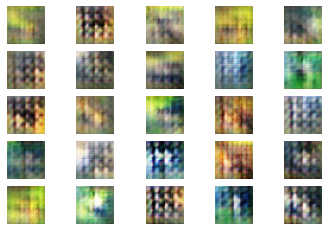

>31, 1/39, d1=0.667, d2=0.648 g=1.375
>31, 2/39, d1=0.911, d2=0.452 g=1.295
>31, 3/39, d1=0.741, d2=0.423 g=1.253
>31, 4/39, d1=0.647, d2=0.465 g=1.255
>31, 5/39, d1=0.561, d2=0.646 g=1.153
>31, 6/39, d1=0.501, d2=0.640 g=1.096
>31, 7/39, d1=0.505, d2=0.637 g=1.046
>31, 8/39, d1=0.537, d2=0.669 g=1.043
>31, 9/39, d1=0.471, d2=0.570 g=1.157
>31, 10/39, d1=0.458, d2=0.559 g=1.244
>31, 11/39, d1=0.322, d2=0.535 g=1.388
>31, 12/39, d1=0.322, d2=0.444 g=1.562
>31, 13/39, d1=0.367, d2=0.798 g=1.564
>31, 14/39, d1=0.620, d2=0.783 g=1.040
>31, 15/39, d1=0.848, d2=0.838 g=1.137
>31, 16/39, d1=0.582, d2=0.331 g=1.449
>31, 17/39, d1=0.366, d2=0.438 g=1.547
>31, 18/39, d1=0.273, d2=1.097 g=1.341
>31, 19/39, d1=0.625, d2=0.562 g=1.676
>31, 20/39, d1=0.721, d2=0.326 g=1.660
>31, 21/39, d1=0.586, d2=0.380 g=1.523
>31, 22/39, d1=0.486, d2=0.678 g=1.448
>31, 23/39, d1=0.529, d2=0.706 g=1.446
>31, 24/39, d1=0.528, d2=0.750 g=1.376
>31, 25/39, d1=0.685, d2=0.785 g=1.235
>31, 26/39, d1=0.759, d2=0.585 g=1

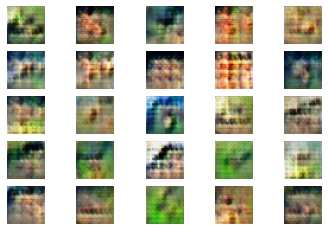

>36, 1/39, d1=0.496, d2=0.602 g=1.506
>36, 2/39, d1=0.671, d2=0.414 g=1.446
>36, 3/39, d1=0.664, d2=0.547 g=1.281
>36, 4/39, d1=0.649, d2=0.648 g=1.172
>36, 5/39, d1=0.687, d2=0.683 g=1.083
>36, 6/39, d1=0.713, d2=0.733 g=1.179
>36, 7/39, d1=0.600, d2=0.493 g=1.267
>36, 8/39, d1=0.593, d2=0.423 g=1.315
>36, 9/39, d1=0.453, d2=0.668 g=1.213
>36, 10/39, d1=0.472, d2=0.785 g=1.176
>36, 11/39, d1=0.716, d2=0.537 g=1.101
>36, 12/39, d1=0.602, d2=0.624 g=1.056
>36, 13/39, d1=0.516, d2=0.584 g=1.101
>36, 14/39, d1=0.384, d2=0.633 g=1.171
>36, 15/39, d1=0.477, d2=0.581 g=1.092
>36, 16/39, d1=0.502, d2=0.668 g=1.157
>36, 17/39, d1=0.578, d2=0.619 g=1.145
>36, 18/39, d1=0.534, d2=0.619 g=1.030
>36, 19/39, d1=0.520, d2=0.697 g=1.089
>36, 20/39, d1=0.521, d2=0.726 g=1.198
>36, 21/39, d1=0.698, d2=0.612 g=1.187
>36, 22/39, d1=0.693, d2=0.768 g=1.103
>36, 23/39, d1=0.709, d2=0.653 g=1.137
>36, 24/39, d1=0.619, d2=0.626 g=1.139
>36, 25/39, d1=0.684, d2=0.616 g=1.203
>36, 26/39, d1=0.827, d2=0.641 g=1

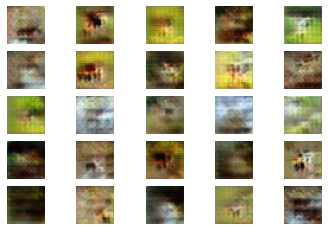

>41, 1/39, d1=0.495, d2=0.560 g=1.165
>41, 2/39, d1=0.539, d2=0.744 g=1.258
>41, 3/39, d1=0.631, d2=0.577 g=1.216
>41, 4/39, d1=0.685, d2=0.620 g=1.270
>41, 5/39, d1=0.696, d2=0.563 g=1.258
>41, 6/39, d1=0.676, d2=0.469 g=1.302
>41, 7/39, d1=0.558, d2=0.500 g=1.186
>41, 8/39, d1=0.429, d2=0.570 g=1.220
>41, 9/39, d1=0.413, d2=0.838 g=1.201
>41, 10/39, d1=0.440, d2=0.566 g=1.109
>41, 11/39, d1=0.756, d2=0.883 g=1.039
>41, 12/39, d1=0.678, d2=0.615 g=1.099
>41, 13/39, d1=0.606, d2=0.571 g=1.110
>41, 14/39, d1=0.699, d2=0.558 g=1.131
>41, 15/39, d1=0.616, d2=0.558 g=1.248
>41, 16/39, d1=0.489, d2=0.491 g=1.354
>41, 17/39, d1=0.608, d2=0.483 g=1.275
>41, 18/39, d1=0.488, d2=0.690 g=1.464
>41, 19/39, d1=0.548, d2=0.335 g=1.429
>41, 20/39, d1=0.552, d2=0.515 g=1.395
>41, 21/39, d1=0.454, d2=0.490 g=1.400
>41, 22/39, d1=0.504, d2=0.586 g=1.247
>41, 23/39, d1=0.407, d2=0.620 g=1.187
>41, 24/39, d1=0.561, d2=0.703 g=1.134
>41, 25/39, d1=0.481, d2=0.676 g=1.159
>41, 26/39, d1=0.810, d2=0.596 g=1

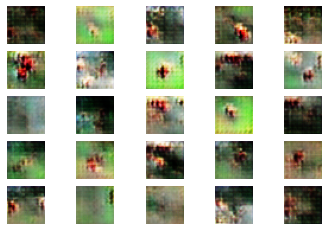

>46, 1/39, d1=0.471, d2=0.502 g=1.235
>46, 2/39, d1=0.593, d2=0.532 g=1.158
>46, 3/39, d1=0.553, d2=0.622 g=1.292
>46, 4/39, d1=0.442, d2=0.565 g=1.390
>46, 5/39, d1=0.533, d2=0.463 g=1.349
>46, 6/39, d1=0.657, d2=0.528 g=1.314
>46, 7/39, d1=0.572, d2=0.532 g=1.339
>46, 8/39, d1=0.581, d2=0.509 g=1.324
>46, 9/39, d1=0.617, d2=0.534 g=1.256
>46, 10/39, d1=0.563, d2=0.528 g=1.265
>46, 11/39, d1=0.625, d2=0.573 g=1.218
>46, 12/39, d1=0.502, d2=0.563 g=1.344
>46, 13/39, d1=0.662, d2=0.512 g=1.306
>46, 14/39, d1=0.547, d2=0.515 g=1.407
>46, 15/39, d1=0.577, d2=0.532 g=1.257
>46, 16/39, d1=0.617, d2=0.639 g=1.173
>46, 17/39, d1=0.497, d2=0.530 g=1.178
>46, 18/39, d1=0.596, d2=0.509 g=1.108
>46, 19/39, d1=0.519, d2=0.678 g=1.092
>46, 20/39, d1=0.515, d2=0.708 g=1.186
>46, 21/39, d1=0.494, d2=0.512 g=1.397
>46, 22/39, d1=0.655, d2=0.465 g=1.279
>46, 23/39, d1=0.460, d2=0.562 g=1.253
>46, 24/39, d1=0.464, d2=0.509 g=1.299
>46, 25/39, d1=0.631, d2=0.461 g=1.237
>46, 26/39, d1=0.503, d2=0.598 g=1

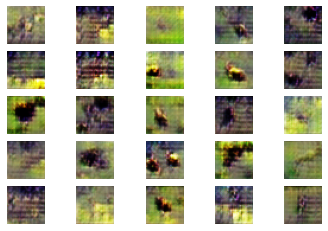

>51, 1/39, d1=0.493, d2=0.488 g=1.256
>51, 2/39, d1=0.527, d2=0.628 g=1.221
>51, 3/39, d1=0.555, d2=0.705 g=1.313
>51, 4/39, d1=0.551, d2=0.498 g=1.364
>51, 5/39, d1=0.593, d2=0.622 g=1.479
>51, 6/39, d1=0.669, d2=0.445 g=1.420
>51, 7/39, d1=0.634, d2=0.493 g=1.327
>51, 8/39, d1=0.678, d2=0.583 g=1.352
>51, 9/39, d1=0.593, d2=0.512 g=1.279
>51, 10/39, d1=0.475, d2=0.595 g=1.289
>51, 11/39, d1=0.657, d2=0.544 g=1.174
>51, 12/39, d1=0.715, d2=0.601 g=1.051
>51, 13/39, d1=0.765, d2=0.721 g=1.057
>51, 14/39, d1=0.587, d2=0.572 g=1.166
>51, 15/39, d1=0.714, d2=0.511 g=1.391
>51, 16/39, d1=0.593, d2=0.456 g=1.460
>51, 17/39, d1=0.607, d2=0.510 g=1.340
>51, 18/39, d1=0.590, d2=0.590 g=1.419
>51, 19/39, d1=0.686, d2=0.594 g=1.420
>51, 20/39, d1=0.659, d2=0.569 g=1.259
>51, 21/39, d1=0.689, d2=0.600 g=1.155
>51, 22/39, d1=0.592, d2=0.589 g=1.157
>51, 23/39, d1=0.555, d2=0.518 g=1.148
>51, 24/39, d1=0.523, d2=0.584 g=1.190
>51, 25/39, d1=0.452, d2=0.564 g=1.153
>51, 26/39, d1=0.474, d2=0.548 g=1

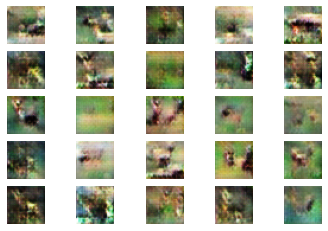

>56, 1/39, d1=0.493, d2=0.487 g=1.060
>56, 2/39, d1=0.541, d2=0.655 g=1.173
>56, 3/39, d1=0.610, d2=0.496 g=1.206
>56, 4/39, d1=0.500, d2=0.578 g=1.272
>56, 5/39, d1=0.641, d2=0.506 g=1.309
>56, 6/39, d1=0.631, d2=0.559 g=1.207
>56, 7/39, d1=0.552, d2=0.624 g=1.363
>56, 8/39, d1=0.676, d2=0.663 g=1.306
>56, 9/39, d1=0.616, d2=0.437 g=1.217
>56, 10/39, d1=0.574, d2=0.604 g=1.245
>56, 11/39, d1=0.635, d2=0.576 g=1.226
>56, 12/39, d1=0.623, d2=0.487 g=1.252
>56, 13/39, d1=0.588, d2=0.487 g=1.265
>56, 14/39, d1=0.500, d2=0.483 g=1.229
>56, 15/39, d1=0.482, d2=0.659 g=1.439
>56, 16/39, d1=0.677, d2=0.383 g=1.276
>56, 17/39, d1=0.591, d2=0.501 g=1.273
>56, 18/39, d1=0.490, d2=0.630 g=1.283
>56, 19/39, d1=0.547, d2=0.698 g=1.342
>56, 20/39, d1=0.559, d2=0.474 g=1.262
>56, 21/39, d1=0.608, d2=0.769 g=1.314
>56, 22/39, d1=0.676, d2=0.525 g=1.187
>56, 23/39, d1=0.726, d2=0.629 g=1.164
>56, 24/39, d1=0.686, d2=0.559 g=1.218
>56, 25/39, d1=0.709, d2=0.575 g=1.132
>56, 26/39, d1=0.654, d2=0.567 g=1

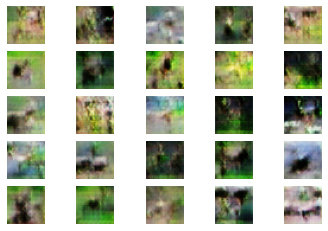

>61, 1/39, d1=0.509, d2=0.507 g=1.281
>61, 2/39, d1=0.603, d2=0.528 g=1.311
>61, 3/39, d1=0.503, d2=0.602 g=1.308
>61, 4/39, d1=0.645, d2=0.531 g=1.187
>61, 5/39, d1=0.674, d2=0.568 g=1.209
>61, 6/39, d1=0.502, d2=0.707 g=1.089
>61, 7/39, d1=0.657, d2=0.678 g=1.181
>61, 8/39, d1=0.592, d2=0.457 g=1.138
>61, 9/39, d1=0.566, d2=0.508 g=1.124
>61, 10/39, d1=0.571, d2=0.615 g=1.142
>61, 11/39, d1=0.463, d2=0.478 g=1.234
>61, 12/39, d1=0.567, d2=0.593 g=1.217
>61, 13/39, d1=0.576, d2=0.608 g=1.205
>61, 14/39, d1=0.571, d2=0.555 g=1.181
>61, 15/39, d1=0.523, d2=0.551 g=1.165
>61, 16/39, d1=0.579, d2=0.576 g=1.273
>61, 17/39, d1=0.565, d2=0.515 g=1.323
>61, 18/39, d1=0.808, d2=0.453 g=1.249
>61, 19/39, d1=0.534, d2=0.526 g=1.219
>61, 20/39, d1=0.476, d2=0.517 g=1.418
>61, 21/39, d1=0.578, d2=0.390 g=1.370
>61, 22/39, d1=0.600, d2=0.631 g=1.362
>61, 23/39, d1=0.562, d2=0.433 g=1.386
>61, 24/39, d1=0.559, d2=0.426 g=1.332
>61, 25/39, d1=0.718, d2=0.668 g=1.292
>61, 26/39, d1=0.629, d2=0.521 g=1

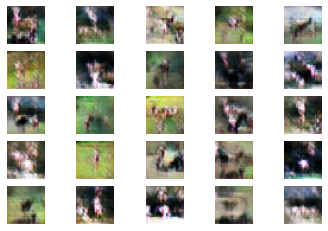

>66, 1/39, d1=0.448, d2=0.658 g=1.346
>66, 2/39, d1=0.600, d2=0.482 g=1.319
>66, 3/39, d1=0.571, d2=0.548 g=1.198
>66, 4/39, d1=0.693, d2=0.516 g=1.130
>66, 5/39, d1=0.474, d2=0.533 g=1.118
>66, 6/39, d1=0.418, d2=0.630 g=1.113
>66, 7/39, d1=0.513, d2=0.949 g=1.248
>66, 8/39, d1=0.735, d2=0.499 g=1.108
>66, 9/39, d1=0.785, d2=0.514 g=1.045
>66, 10/39, d1=0.510, d2=0.536 g=1.043
>66, 11/39, d1=0.504, d2=0.648 g=1.015
>66, 12/39, d1=0.609, d2=0.644 g=1.133
>66, 13/39, d1=0.429, d2=0.560 g=1.168
>66, 14/39, d1=0.471, d2=0.530 g=1.248
>66, 15/39, d1=0.500, d2=0.510 g=1.289
>66, 16/39, d1=0.438, d2=0.484 g=1.239
>66, 17/39, d1=0.369, d2=0.727 g=1.304
>66, 18/39, d1=0.604, d2=0.489 g=1.330
>66, 19/39, d1=0.486, d2=0.754 g=1.466
>66, 20/39, d1=0.909, d2=0.380 g=1.337
>66, 21/39, d1=0.653, d2=0.702 g=1.347
>66, 22/39, d1=0.795, d2=0.460 g=1.160
>66, 23/39, d1=0.619, d2=0.599 g=1.128
>66, 24/39, d1=0.581, d2=0.542 g=1.075
>66, 25/39, d1=0.588, d2=0.521 g=1.132
>66, 26/39, d1=0.667, d2=0.604 g=1

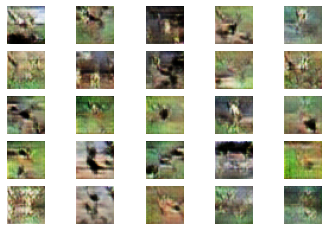

>71, 1/39, d1=0.511, d2=0.567 g=1.119
>71, 2/39, d1=0.477, d2=0.570 g=1.175
>71, 3/39, d1=0.576, d2=0.576 g=1.144
>71, 4/39, d1=0.581, d2=0.540 g=1.146
>71, 5/39, d1=0.489, d2=0.553 g=1.105
>71, 6/39, d1=0.523, d2=0.521 g=1.120
>71, 7/39, d1=0.548, d2=0.605 g=1.149
>71, 8/39, d1=0.623, d2=0.633 g=1.113
>71, 9/39, d1=0.460, d2=0.589 g=1.150
>71, 10/39, d1=0.586, d2=0.492 g=1.239
>71, 11/39, d1=0.547, d2=0.545 g=1.219
>71, 12/39, d1=0.612, d2=0.525 g=1.143
>71, 13/39, d1=0.693, d2=0.647 g=1.114
>71, 14/39, d1=0.615, d2=0.726 g=1.130
>71, 15/39, d1=0.759, d2=0.631 g=1.063
>71, 16/39, d1=0.814, d2=0.624 g=1.090
>71, 17/39, d1=0.794, d2=0.480 g=1.143
>71, 18/39, d1=0.619, d2=0.533 g=1.153
>71, 19/39, d1=0.610, d2=0.454 g=1.102
>71, 20/39, d1=0.614, d2=0.528 g=1.062
>71, 21/39, d1=0.539, d2=0.643 g=1.138
>71, 22/39, d1=0.682, d2=0.485 g=1.131
>71, 23/39, d1=0.611, d2=0.506 g=1.127
>71, 24/39, d1=0.627, d2=0.505 g=1.035
>71, 25/39, d1=0.532, d2=0.759 g=1.139
>71, 26/39, d1=0.556, d2=0.545 g=1

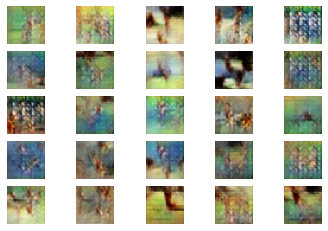

>76, 1/39, d1=0.482, d2=0.562 g=1.177
>76, 2/39, d1=0.501, d2=0.490 g=1.180
>76, 3/39, d1=0.437, d2=0.503 g=1.156
>76, 4/39, d1=0.476, d2=0.626 g=1.175
>76, 5/39, d1=0.518, d2=0.589 g=1.169
>76, 6/39, d1=0.555, d2=0.559 g=1.152
>76, 7/39, d1=0.422, d2=0.544 g=1.114
>76, 8/39, d1=0.413, d2=0.685 g=1.272
>76, 9/39, d1=0.551, d2=0.471 g=1.276
>76, 10/39, d1=0.483, d2=0.547 g=1.414
>76, 11/39, d1=0.438, d2=0.496 g=1.347
>76, 12/39, d1=0.475, d2=0.803 g=1.505
>76, 13/39, d1=0.639, d2=0.358 g=1.364
>76, 14/39, d1=0.727, d2=0.490 g=1.167
>76, 15/39, d1=0.694, d2=0.615 g=1.156
>76, 16/39, d1=0.722, d2=0.528 g=1.179
>76, 17/39, d1=0.733, d2=0.470 g=1.188
>76, 18/39, d1=0.750, d2=0.638 g=1.183
>76, 19/39, d1=0.607, d2=0.526 g=1.102
>76, 20/39, d1=0.596, d2=0.757 g=1.163
>76, 21/39, d1=0.722, d2=0.560 g=1.176
>76, 22/39, d1=0.735, d2=0.500 g=1.147
>76, 23/39, d1=0.575, d2=0.611 g=1.096
>76, 24/39, d1=0.623, d2=0.595 g=0.974
>76, 25/39, d1=0.511, d2=0.829 g=1.071
>76, 26/39, d1=0.668, d2=0.552 g=1

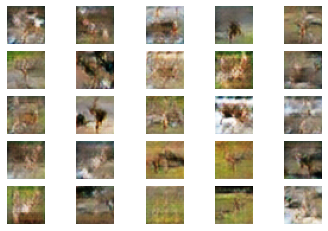

>81, 1/39, d1=0.503, d2=0.662 g=1.112
>81, 2/39, d1=0.583, d2=0.623 g=1.203
>81, 3/39, d1=0.417, d2=0.610 g=1.179
>81, 4/39, d1=0.458, d2=0.762 g=1.132
>81, 5/39, d1=0.567, d2=0.595 g=1.267
>81, 6/39, d1=0.742, d2=0.541 g=1.151
>81, 7/39, d1=0.652, d2=0.700 g=1.112
>81, 8/39, d1=0.695, d2=0.547 g=1.176
>81, 9/39, d1=0.619, d2=0.509 g=1.303
>81, 10/39, d1=0.616, d2=0.475 g=1.391
>81, 11/39, d1=0.629, d2=0.467 g=1.297
>81, 12/39, d1=0.500, d2=0.516 g=1.343
>81, 13/39, d1=0.575, d2=0.488 g=1.321
>81, 14/39, d1=0.507, d2=0.574 g=1.324
>81, 15/39, d1=0.646, d2=0.540 g=1.279
>81, 16/39, d1=0.586, d2=0.519 g=1.198
>81, 17/39, d1=0.574, d2=0.481 g=1.137
>81, 18/39, d1=0.484, d2=0.568 g=1.111
>81, 19/39, d1=0.552, d2=0.830 g=1.246
>81, 20/39, d1=0.545, d2=0.397 g=1.251
>81, 21/39, d1=0.516, d2=0.544 g=1.160
>81, 22/39, d1=0.562, d2=0.714 g=1.163
>81, 23/39, d1=0.440, d2=0.537 g=1.216
>81, 24/39, d1=0.460, d2=0.576 g=1.171
>81, 25/39, d1=0.536, d2=0.728 g=1.240
>81, 26/39, d1=0.570, d2=0.526 g=1

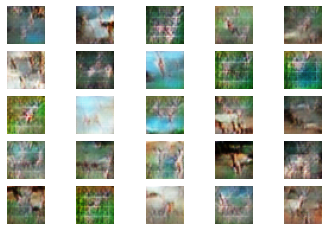

>86, 1/39, d1=0.474, d2=0.497 g=1.255
>86, 2/39, d1=0.558, d2=0.643 g=1.253
>86, 3/39, d1=0.502, d2=0.542 g=1.370
>86, 4/39, d1=0.556, d2=0.529 g=1.384
>86, 5/39, d1=0.526, d2=0.623 g=1.414
>86, 6/39, d1=0.682, d2=0.724 g=1.416
>86, 7/39, d1=0.631, d2=0.559 g=1.261
>86, 8/39, d1=0.578, d2=0.506 g=1.281
>86, 9/39, d1=0.667, d2=0.589 g=1.422
>86, 10/39, d1=0.669, d2=0.405 g=1.379
>86, 11/39, d1=0.595, d2=0.538 g=1.300
>86, 12/39, d1=0.586, d2=0.880 g=1.305
>86, 13/39, d1=0.693, d2=0.597 g=1.213
>86, 14/39, d1=0.693, d2=0.502 g=1.144
>86, 15/39, d1=0.755, d2=0.544 g=1.118
>86, 16/39, d1=0.683, d2=0.522 g=1.100
>86, 17/39, d1=0.606, d2=0.538 g=1.107
>86, 18/39, d1=0.585, d2=0.513 g=1.135
>86, 19/39, d1=0.529, d2=0.561 g=1.247
>86, 20/39, d1=0.571, d2=0.501 g=1.213
>86, 21/39, d1=0.534, d2=0.527 g=1.151
>86, 22/39, d1=0.756, d2=0.578 g=1.112
>86, 23/39, d1=0.583, d2=0.599 g=1.156
>86, 24/39, d1=0.603, d2=0.595 g=1.208
>86, 25/39, d1=0.610, d2=0.447 g=1.188
>86, 26/39, d1=0.514, d2=0.490 g=1

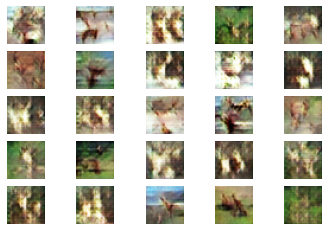

>91, 1/39, d1=0.486, d2=0.528 g=1.218
>91, 2/39, d1=0.606, d2=0.515 g=1.305
>91, 3/39, d1=0.641, d2=0.480 g=1.228
>91, 4/39, d1=0.557, d2=0.522 g=1.220
>91, 5/39, d1=0.550, d2=0.542 g=1.231
>91, 6/39, d1=0.464, d2=0.511 g=1.228
>91, 7/39, d1=0.505, d2=0.514 g=1.266
>91, 8/39, d1=0.508, d2=0.570 g=1.187
>91, 9/39, d1=0.622, d2=0.660 g=1.256
>91, 10/39, d1=0.565, d2=0.533 g=1.218
>91, 11/39, d1=0.599, d2=0.629 g=1.152
>91, 12/39, d1=0.486, d2=0.543 g=1.136
>91, 13/39, d1=0.544, d2=0.780 g=1.204
>91, 14/39, d1=0.643, d2=0.477 g=1.105
>91, 15/39, d1=0.526, d2=0.589 g=1.033
>91, 16/39, d1=0.414, d2=0.847 g=1.086
>91, 17/39, d1=0.440, d2=0.671 g=1.211
>91, 18/39, d1=0.571, d2=0.535 g=1.344
>91, 19/39, d1=0.585, d2=0.666 g=1.439
>91, 20/39, d1=0.844, d2=0.456 g=1.376
>91, 21/39, d1=0.530, d2=0.742 g=1.559
>91, 22/39, d1=0.664, d2=0.392 g=1.404
>91, 23/39, d1=0.601, d2=0.446 g=1.225
>91, 24/39, d1=0.516, d2=0.570 g=1.304
>91, 25/39, d1=0.456, d2=0.518 g=1.338
>91, 26/39, d1=0.607, d2=0.540 g=1

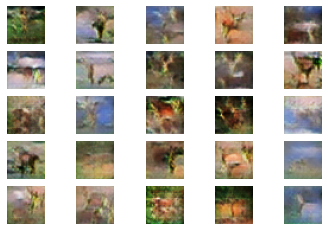

>96, 1/39, d1=0.519, d2=0.505 g=1.113
>96, 2/39, d1=0.680, d2=0.612 g=1.149
>96, 3/39, d1=0.585, d2=0.476 g=1.119
>96, 4/39, d1=0.636, d2=0.458 g=1.186
>96, 5/39, d1=0.421, d2=0.486 g=1.127
>96, 6/39, d1=0.454, d2=0.593 g=1.151
>96, 7/39, d1=0.466, d2=0.553 g=1.265
>96, 8/39, d1=0.540, d2=0.463 g=1.272
>96, 9/39, d1=0.658, d2=0.717 g=1.312
>96, 10/39, d1=0.575, d2=0.412 g=1.290
>96, 11/39, d1=0.614, d2=0.464 g=1.238
>96, 12/39, d1=0.488, d2=0.563 g=1.189
>96, 13/39, d1=0.485, d2=0.502 g=1.208
>96, 14/39, d1=0.498, d2=0.562 g=1.304
>96, 15/39, d1=0.487, d2=0.469 g=1.325
>96, 16/39, d1=0.586, d2=0.531 g=1.297
>96, 17/39, d1=0.595, d2=0.752 g=1.336
>96, 18/39, d1=0.505, d2=0.488 g=1.351
>96, 19/39, d1=0.711, d2=0.449 g=1.198
>96, 20/39, d1=0.628, d2=0.580 g=1.160
>96, 21/39, d1=0.504, d2=0.652 g=1.161
>96, 22/39, d1=0.490, d2=0.519 g=1.214
>96, 23/39, d1=0.525, d2=0.547 g=1.213
>96, 24/39, d1=0.527, d2=0.537 g=1.214
>96, 25/39, d1=0.746, d2=0.425 g=1.194
>96, 26/39, d1=0.646, d2=0.657 g=1

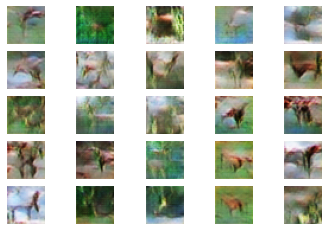

>101, 1/39, d1=0.443, d2=0.638 g=1.239
>101, 2/39, d1=0.594, d2=0.520 g=1.208
>101, 3/39, d1=0.647, d2=0.538 g=1.179
>101, 4/39, d1=0.567, d2=0.650 g=1.119
>101, 5/39, d1=0.552, d2=0.650 g=1.218
>101, 6/39, d1=0.603, d2=0.476 g=1.295
>101, 7/39, d1=0.539, d2=0.469 g=1.261
>101, 8/39, d1=0.661, d2=0.593 g=1.260
>101, 9/39, d1=0.679, d2=0.557 g=1.336
>101, 10/39, d1=0.695, d2=0.469 g=1.219
>101, 11/39, d1=0.596, d2=0.507 g=1.172
>101, 12/39, d1=0.671, d2=0.628 g=1.240
>101, 13/39, d1=0.763, d2=0.636 g=1.183
>101, 14/39, d1=0.472, d2=0.529 g=1.101
>101, 15/39, d1=0.563, d2=0.624 g=1.178
>101, 16/39, d1=0.595, d2=0.602 g=1.195
>101, 17/39, d1=0.543, d2=0.574 g=1.205
>101, 18/39, d1=0.584, d2=0.438 g=1.166
>101, 19/39, d1=0.615, d2=0.596 g=1.041
>101, 20/39, d1=0.453, d2=0.620 g=1.147
>101, 21/39, d1=0.647, d2=0.549 g=1.097
>101, 22/39, d1=0.670, d2=0.578 g=1.117
>101, 23/39, d1=0.649, d2=0.555 g=1.050
>101, 24/39, d1=0.511, d2=0.568 g=1.115
>101, 25/39, d1=0.538, d2=0.524 g=1.116
>101, 26/

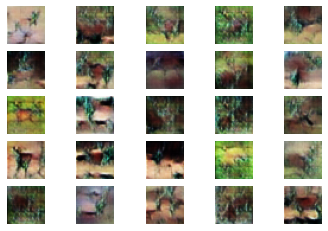

>106, 1/39, d1=0.419, d2=0.445 g=1.236
>106, 2/39, d1=0.401, d2=0.582 g=1.404
>106, 3/39, d1=0.511, d2=0.373 g=1.452
>106, 4/39, d1=0.637, d2=0.418 g=1.312
>106, 5/39, d1=0.420, d2=0.523 g=1.367
>106, 6/39, d1=0.480, d2=0.631 g=1.369
>106, 7/39, d1=0.452, d2=0.460 g=1.381
>106, 8/39, d1=0.465, d2=0.579 g=1.428
>106, 9/39, d1=0.478, d2=0.504 g=1.352
>106, 10/39, d1=0.462, d2=0.668 g=1.412
>106, 11/39, d1=0.613, d2=0.428 g=1.342
>106, 12/39, d1=0.541, d2=0.591 g=1.391
>106, 13/39, d1=0.760, d2=0.425 g=1.338
>106, 14/39, d1=0.609, d2=0.592 g=1.319
>106, 15/39, d1=0.467, d2=0.466 g=1.292
>106, 16/39, d1=0.560, d2=0.812 g=1.405
>106, 17/39, d1=0.775, d2=0.353 g=1.313
>106, 18/39, d1=0.783, d2=0.639 g=1.166
>106, 19/39, d1=0.668, d2=0.571 g=1.169
>106, 20/39, d1=0.590, d2=0.484 g=1.190
>106, 21/39, d1=0.579, d2=0.511 g=1.128
>106, 22/39, d1=0.557, d2=0.585 g=1.188
>106, 23/39, d1=0.632, d2=0.510 g=1.128
>106, 24/39, d1=0.551, d2=0.622 g=1.185
>106, 25/39, d1=0.637, d2=0.534 g=1.210
>106, 26/

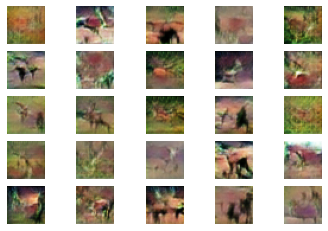

>111, 1/39, d1=0.413, d2=0.543 g=1.246
>111, 2/39, d1=0.525, d2=0.637 g=1.295
>111, 3/39, d1=0.429, d2=0.551 g=1.334
>111, 4/39, d1=0.523, d2=0.660 g=1.441
>111, 5/39, d1=0.685, d2=0.410 g=1.498
>111, 6/39, d1=0.726, d2=0.508 g=1.316
>111, 7/39, d1=0.595, d2=0.594 g=1.330
>111, 8/39, d1=0.515, d2=0.619 g=1.324
>111, 9/39, d1=0.529, d2=0.411 g=1.318
>111, 10/39, d1=0.632, d2=0.568 g=1.311
>111, 11/39, d1=0.497, d2=0.524 g=1.261
>111, 12/39, d1=0.590, d2=0.518 g=1.304
>111, 13/39, d1=0.575, d2=0.484 g=1.222
>111, 14/39, d1=0.689, d2=0.583 g=1.239
>111, 15/39, d1=0.774, d2=0.468 g=1.166
>111, 16/39, d1=0.575, d2=0.469 g=1.169
>111, 17/39, d1=0.629, d2=0.581 g=1.187
>111, 18/39, d1=0.441, d2=0.555 g=1.123
>111, 19/39, d1=0.506, d2=0.588 g=1.225
>111, 20/39, d1=0.624, d2=0.586 g=1.166
>111, 21/39, d1=0.523, d2=0.538 g=1.266
>111, 22/39, d1=0.376, d2=0.650 g=1.398
>111, 23/39, d1=0.604, d2=0.398 g=1.444
>111, 24/39, d1=0.530, d2=0.412 g=1.325
>111, 25/39, d1=0.446, d2=0.550 g=1.384
>111, 26/

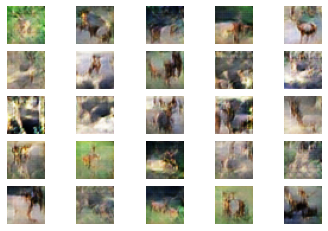

>116, 1/39, d1=0.412, d2=0.571 g=1.276
>116, 2/39, d1=0.448, d2=0.746 g=1.323
>116, 3/39, d1=0.609, d2=0.472 g=1.279
>116, 4/39, d1=0.600, d2=0.576 g=1.172
>116, 5/39, d1=0.588, d2=0.595 g=1.206
>116, 6/39, d1=0.673, d2=0.490 g=1.300
>116, 7/39, d1=0.593, d2=0.474 g=1.211
>116, 8/39, d1=0.582, d2=0.470 g=1.182
>116, 9/39, d1=0.524, d2=0.602 g=1.146
>116, 10/39, d1=0.456, d2=0.552 g=1.156
>116, 11/39, d1=0.611, d2=0.460 g=1.189
>116, 12/39, d1=0.511, d2=0.522 g=1.262
>116, 13/39, d1=0.451, d2=0.496 g=1.353
>116, 14/39, d1=0.500, d2=0.535 g=1.400
>116, 15/39, d1=0.557, d2=0.516 g=1.406
>116, 16/39, d1=0.407, d2=0.516 g=1.368
>116, 17/39, d1=0.532, d2=0.504 g=1.427
>116, 18/39, d1=0.537, d2=0.617 g=1.350
>116, 19/39, d1=0.749, d2=0.467 g=1.164
>116, 20/39, d1=0.521, d2=0.607 g=1.187
>116, 21/39, d1=0.582, d2=0.641 g=1.380
>116, 22/39, d1=0.704, d2=0.485 g=1.274
>116, 23/39, d1=0.612, d2=0.508 g=1.272
>116, 24/39, d1=0.573, d2=0.558 g=1.263
>116, 25/39, d1=0.445, d2=0.594 g=1.309
>116, 26/

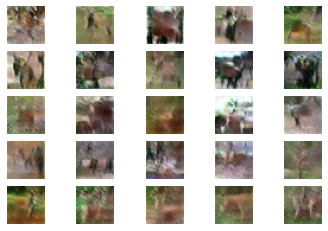

>121, 1/39, d1=0.521, d2=0.594 g=1.202
>121, 2/39, d1=0.462, d2=0.647 g=1.316
>121, 3/39, d1=0.437, d2=0.467 g=1.402
>121, 4/39, d1=0.528, d2=0.461 g=1.435
>121, 5/39, d1=0.578, d2=0.443 g=1.409
>121, 6/39, d1=0.555, d2=0.451 g=1.322
>121, 7/39, d1=0.458, d2=0.791 g=1.618
>121, 8/39, d1=0.693, d2=0.325 g=1.503
>121, 9/39, d1=0.695, d2=0.354 g=1.327
>121, 10/39, d1=0.476, d2=0.535 g=1.280
>121, 11/39, d1=0.448, d2=0.640 g=1.273
>121, 12/39, d1=0.477, d2=0.499 g=1.455
>121, 13/39, d1=0.589, d2=0.469 g=1.271
>121, 14/39, d1=0.437, d2=0.669 g=1.468
>121, 15/39, d1=0.527, d2=0.515 g=1.491
>121, 16/39, d1=0.629, d2=0.559 g=1.453
>121, 17/39, d1=0.647, d2=0.576 g=1.371
>121, 18/39, d1=0.543, d2=0.435 g=1.318
>121, 19/39, d1=0.530, d2=0.679 g=1.353
>121, 20/39, d1=0.600, d2=0.377 g=1.492
>121, 21/39, d1=0.566, d2=0.612 g=1.603
>121, 22/39, d1=0.619, d2=0.387 g=1.678
>121, 23/39, d1=0.508, d2=0.362 g=1.624
>121, 24/39, d1=0.482, d2=0.476 g=1.526
>121, 25/39, d1=0.481, d2=0.450 g=1.518
>121, 26/

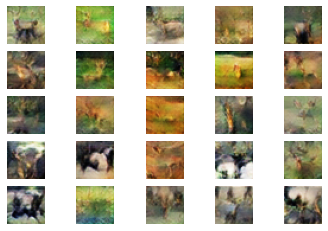

>126, 1/39, d1=0.458, d2=0.461 g=1.120
>126, 2/39, d1=0.531, d2=0.569 g=1.170
>126, 3/39, d1=0.439, d2=0.567 g=1.234
>126, 4/39, d1=0.579, d2=0.501 g=1.191
>126, 5/39, d1=0.507, d2=0.572 g=1.155
>126, 6/39, d1=0.543, d2=0.654 g=1.303
>126, 7/39, d1=0.532, d2=0.479 g=1.314
>126, 8/39, d1=0.582, d2=0.701 g=1.410
>126, 9/39, d1=0.720, d2=0.357 g=1.322
>126, 10/39, d1=0.518, d2=0.656 g=1.368
>126, 11/39, d1=0.674, d2=0.450 g=1.291
>126, 12/39, d1=0.650, d2=0.522 g=1.245
>126, 13/39, d1=0.632, d2=0.552 g=1.163
>126, 14/39, d1=0.576, d2=0.617 g=1.230
>126, 15/39, d1=0.519, d2=0.639 g=1.257
>126, 16/39, d1=0.584, d2=0.382 g=1.324
>126, 17/39, d1=0.570, d2=0.423 g=1.248
>126, 18/39, d1=0.497, d2=0.534 g=1.252
>126, 19/39, d1=0.615, d2=0.607 g=1.150
>126, 20/39, d1=0.501, d2=0.514 g=1.234
>126, 21/39, d1=0.486, d2=0.638 g=1.329
>126, 22/39, d1=0.516, d2=0.470 g=1.210
>126, 23/39, d1=0.481, d2=0.480 g=1.156
>126, 24/39, d1=0.508, d2=0.793 g=1.311
>126, 25/39, d1=0.637, d2=0.414 g=1.307
>126, 26/

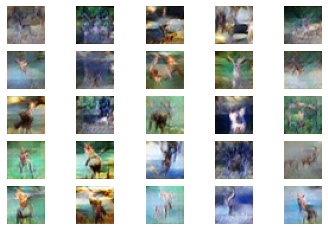

>131, 1/39, d1=0.489, d2=0.631 g=1.373
>131, 2/39, d1=0.587, d2=0.454 g=1.309
>131, 3/39, d1=0.650, d2=0.498 g=1.207
>131, 4/39, d1=0.463, d2=0.557 g=1.208
>131, 5/39, d1=0.299, d2=0.552 g=1.291
>131, 6/39, d1=0.532, d2=0.700 g=1.427
>131, 7/39, d1=0.667, d2=0.434 g=1.442
>131, 8/39, d1=0.684, d2=0.384 g=1.342
>131, 9/39, d1=0.593, d2=0.488 g=1.297
>131, 10/39, d1=0.553, d2=0.557 g=1.258
>131, 11/39, d1=0.492, d2=0.567 g=1.301
>131, 12/39, d1=0.542, d2=0.463 g=1.232
>131, 13/39, d1=0.449, d2=0.532 g=1.288
>131, 14/39, d1=0.579, d2=0.445 g=1.307
>131, 15/39, d1=0.550, d2=0.529 g=1.284
>131, 16/39, d1=0.557, d2=0.632 g=1.458
>131, 17/39, d1=0.736, d2=0.407 g=1.388
>131, 18/39, d1=0.553, d2=0.476 g=1.241
>131, 19/39, d1=0.536, d2=0.688 g=1.317
>131, 20/39, d1=0.598, d2=0.483 g=1.301
>131, 21/39, d1=0.679, d2=0.497 g=1.333
>131, 22/39, d1=0.705, d2=0.479 g=1.288
>131, 23/39, d1=0.645, d2=0.512 g=1.276
>131, 24/39, d1=0.553, d2=0.562 g=1.316
>131, 25/39, d1=0.620, d2=0.418 g=1.346
>131, 26/

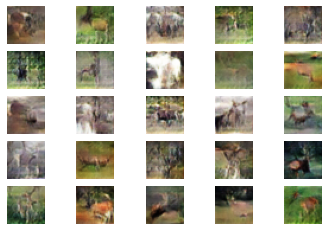

>136, 1/39, d1=0.440, d2=0.598 g=1.389
>136, 2/39, d1=0.584, d2=0.391 g=1.460
>136, 3/39, d1=0.625, d2=0.470 g=1.331
>136, 4/39, d1=0.558, d2=0.748 g=1.229
>136, 5/39, d1=0.581, d2=0.577 g=1.251
>136, 6/39, d1=0.550, d2=0.481 g=1.280
>136, 7/39, d1=0.556, d2=0.604 g=1.310
>136, 8/39, d1=0.388, d2=0.411 g=1.365
>136, 9/39, d1=0.499, d2=0.497 g=1.339
>136, 10/39, d1=0.614, d2=0.544 g=1.284
>136, 11/39, d1=0.456, d2=0.575 g=1.299
>136, 12/39, d1=0.589, d2=0.618 g=1.219
>136, 13/39, d1=0.455, d2=0.483 g=1.313
>136, 14/39, d1=0.629, d2=0.601 g=1.286
>136, 15/39, d1=0.549, d2=0.487 g=1.373
>136, 16/39, d1=0.484, d2=0.591 g=1.455
>136, 17/39, d1=0.623, d2=0.394 g=1.367
>136, 18/39, d1=0.605, d2=0.769 g=1.347
>136, 19/39, d1=0.635, d2=0.509 g=1.381
>136, 20/39, d1=0.683, d2=0.561 g=1.327
>136, 21/39, d1=0.611, d2=0.471 g=1.272
>136, 22/39, d1=0.539, d2=0.623 g=1.263
>136, 23/39, d1=0.422, d2=0.583 g=1.428
>136, 24/39, d1=0.706, d2=0.414 g=1.423
>136, 25/39, d1=0.707, d2=0.462 g=1.306
>136, 26/

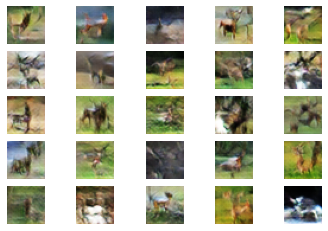

>141, 1/39, d1=0.397, d2=0.398 g=1.364
>141, 2/39, d1=0.518, d2=0.471 g=1.388
>141, 3/39, d1=0.430, d2=0.663 g=1.429
>141, 4/39, d1=0.447, d2=0.485 g=1.492
>141, 5/39, d1=0.650, d2=0.367 g=1.360
>141, 6/39, d1=0.514, d2=0.423 g=1.258
>141, 7/39, d1=0.454, d2=0.716 g=1.377
>141, 8/39, d1=0.574, d2=0.464 g=1.372
>141, 9/39, d1=0.602, d2=0.578 g=1.271
>141, 10/39, d1=0.472, d2=0.613 g=1.236
>141, 11/39, d1=0.556, d2=0.585 g=1.461
>141, 12/39, d1=0.522, d2=0.424 g=1.403
>141, 13/39, d1=0.429, d2=0.605 g=1.507
>141, 14/39, d1=0.518, d2=0.559 g=1.388
>141, 15/39, d1=0.572, d2=0.594 g=1.512
>141, 16/39, d1=0.751, d2=0.528 g=1.415
>141, 17/39, d1=0.583, d2=0.446 g=1.361
>141, 18/39, d1=0.515, d2=0.627 g=1.411
>141, 19/39, d1=0.513, d2=0.603 g=1.377
>141, 20/39, d1=0.451, d2=0.409 g=1.471
>141, 21/39, d1=0.538, d2=0.480 g=1.350
>141, 22/39, d1=0.419, d2=0.580 g=1.492
>141, 23/39, d1=0.648, d2=0.532 g=1.309
>141, 24/39, d1=0.499, d2=0.512 g=1.281
>141, 25/39, d1=0.660, d2=0.462 g=1.339
>141, 26/

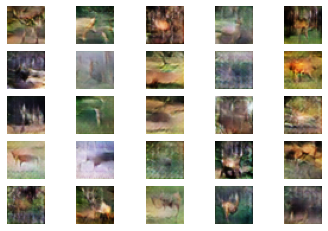

>146, 1/39, d1=0.404, d2=0.401 g=1.421
>146, 2/39, d1=0.353, d2=0.638 g=1.388
>146, 3/39, d1=0.584, d2=0.561 g=1.382
>146, 4/39, d1=0.589, d2=0.470 g=1.333
>146, 5/39, d1=0.556, d2=0.502 g=1.234
>146, 6/39, d1=0.482, d2=0.603 g=1.324
>146, 7/39, d1=0.569, d2=0.610 g=1.460
>146, 8/39, d1=0.724, d2=0.356 g=1.480
>146, 9/39, d1=0.599, d2=0.571 g=1.402
>146, 10/39, d1=0.565, d2=0.463 g=1.439
>146, 11/39, d1=0.572, d2=0.484 g=1.261
>146, 12/39, d1=0.736, d2=0.566 g=1.181
>146, 13/39, d1=0.649, d2=0.595 g=1.235
>146, 14/39, d1=0.646, d2=0.633 g=1.236
>146, 15/39, d1=0.497, d2=0.459 g=1.273
>146, 16/39, d1=0.607, d2=0.435 g=1.292
>146, 17/39, d1=0.432, d2=0.643 g=1.213
>146, 18/39, d1=0.508, d2=0.632 g=1.304
>146, 19/39, d1=0.564, d2=0.447 g=1.338
>146, 20/39, d1=0.471, d2=0.421 g=1.358
>146, 21/39, d1=0.481, d2=0.597 g=1.393
>146, 22/39, d1=0.597, d2=0.390 g=1.350
>146, 23/39, d1=0.559, d2=0.416 g=1.380
>146, 24/39, d1=0.420, d2=0.756 g=1.364
>146, 25/39, d1=0.534, d2=0.412 g=1.423
>146, 26/

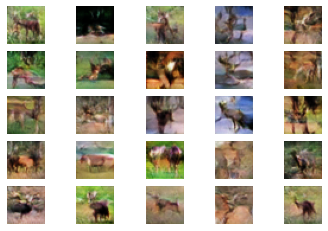

>151, 1/39, d1=0.445, d2=0.432 g=1.338
>151, 2/39, d1=0.653, d2=0.584 g=1.318
>151, 3/39, d1=0.594, d2=0.441 g=1.192
>151, 4/39, d1=0.471, d2=0.561 g=1.062
>151, 5/39, d1=0.436, d2=0.540 g=1.220
>151, 6/39, d1=0.414, d2=0.564 g=1.412
>151, 7/39, d1=0.582, d2=0.391 g=1.400
>151, 8/39, d1=0.713, d2=0.507 g=1.265
>151, 9/39, d1=0.446, d2=0.572 g=1.306
>151, 10/39, d1=0.472, d2=0.476 g=1.288
>151, 11/39, d1=0.585, d2=0.619 g=1.198
>151, 12/39, d1=0.538, d2=0.482 g=1.383
>151, 13/39, d1=0.624, d2=0.524 g=1.304
>151, 14/39, d1=0.591, d2=0.524 g=1.419
>151, 15/39, d1=0.446, d2=0.515 g=1.340
>151, 16/39, d1=0.505, d2=0.454 g=1.267
>151, 17/39, d1=0.608, d2=0.556 g=1.282
>151, 18/39, d1=0.550, d2=0.504 g=1.350
>151, 19/39, d1=0.567, d2=0.547 g=1.313
>151, 20/39, d1=0.522, d2=0.372 g=1.349
>151, 21/39, d1=0.489, d2=0.552 g=1.158
>151, 22/39, d1=0.520, d2=0.551 g=1.281
>151, 23/39, d1=0.593, d2=0.490 g=1.180
>151, 24/39, d1=0.550, d2=0.589 g=1.276
>151, 25/39, d1=0.440, d2=0.554 g=1.406
>151, 26/

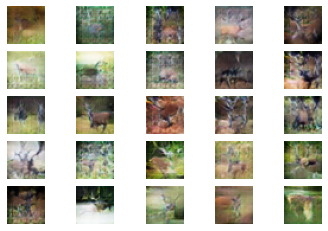

>156, 1/39, d1=0.486, d2=0.558 g=1.256
>156, 2/39, d1=0.571, d2=0.517 g=1.218
>156, 3/39, d1=0.436, d2=0.673 g=1.311
>156, 4/39, d1=0.609, d2=0.463 g=1.315
>156, 5/39, d1=0.462, d2=0.560 g=1.435
>156, 6/39, d1=0.480, d2=0.403 g=1.325
>156, 7/39, d1=0.473, d2=0.535 g=1.312
>156, 8/39, d1=0.616, d2=0.637 g=1.347
>156, 9/39, d1=0.496, d2=0.473 g=1.292
>156, 10/39, d1=0.605, d2=0.489 g=1.387
>156, 11/39, d1=0.653, d2=0.499 g=1.312
>156, 12/39, d1=0.487, d2=0.575 g=1.392
>156, 13/39, d1=0.488, d2=0.471 g=1.581
>156, 14/39, d1=0.522, d2=0.409 g=1.480
>156, 15/39, d1=0.614, d2=0.486 g=1.301
>156, 16/39, d1=0.538, d2=0.596 g=1.379
>156, 17/39, d1=0.513, d2=0.500 g=1.311
>156, 18/39, d1=0.573, d2=0.482 g=1.264
>156, 19/39, d1=0.598, d2=0.530 g=1.240
>156, 20/39, d1=0.524, d2=0.725 g=1.361
>156, 21/39, d1=0.559, d2=0.449 g=1.312
>156, 22/39, d1=0.608, d2=0.542 g=1.259
>156, 23/39, d1=0.508, d2=0.465 g=1.265
>156, 24/39, d1=0.423, d2=0.520 g=1.295
>156, 25/39, d1=0.674, d2=0.447 g=1.255
>156, 26/

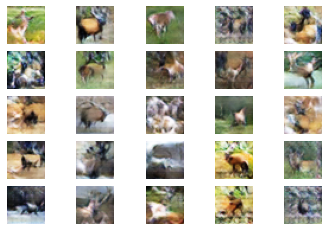

>161, 1/39, d1=0.423, d2=0.692 g=1.396
>161, 2/39, d1=0.564, d2=0.491 g=1.540
>161, 3/39, d1=0.649, d2=0.509 g=1.390
>161, 4/39, d1=0.632, d2=0.628 g=1.383
>161, 5/39, d1=0.598, d2=0.431 g=1.375
>161, 6/39, d1=0.574, d2=0.561 g=1.250
>161, 7/39, d1=0.596, d2=0.588 g=1.298
>161, 8/39, d1=0.490, d2=0.486 g=1.336
>161, 9/39, d1=0.593, d2=0.547 g=1.210
>161, 10/39, d1=0.535, d2=0.466 g=1.265
>161, 11/39, d1=0.559, d2=0.512 g=1.208
>161, 12/39, d1=0.449, d2=0.693 g=1.279
>161, 13/39, d1=0.509, d2=0.547 g=1.370
>161, 14/39, d1=0.477, d2=0.590 g=1.390
>161, 15/39, d1=0.599, d2=0.497 g=1.476
>161, 16/39, d1=0.554, d2=0.461 g=1.468
>161, 17/39, d1=0.597, d2=0.493 g=1.409
>161, 18/39, d1=0.602, d2=0.523 g=1.472
>161, 19/39, d1=0.544, d2=0.572 g=1.309
>161, 20/39, d1=0.493, d2=0.539 g=1.370
>161, 21/39, d1=0.730, d2=0.510 g=1.452
>161, 22/39, d1=0.501, d2=0.427 g=1.481
>161, 23/39, d1=0.566, d2=0.559 g=1.365
>161, 24/39, d1=0.400, d2=0.511 g=1.460
>161, 25/39, d1=0.399, d2=0.574 g=1.696
>161, 26/

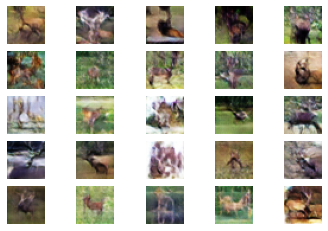

>166, 1/39, d1=0.456, d2=0.469 g=1.398
>166, 2/39, d1=0.384, d2=0.597 g=1.496
>166, 3/39, d1=0.658, d2=0.462 g=1.525
>166, 4/39, d1=0.465, d2=0.544 g=1.734
>166, 5/39, d1=0.623, d2=0.338 g=1.567
>166, 6/39, d1=0.535, d2=0.502 g=1.477
>166, 7/39, d1=0.569, d2=0.460 g=1.284
>166, 8/39, d1=0.595, d2=0.522 g=1.264
>166, 9/39, d1=0.502, d2=0.365 g=1.359
>166, 10/39, d1=0.567, d2=0.526 g=1.419
>166, 11/39, d1=0.442, d2=0.518 g=1.411
>166, 12/39, d1=0.478, d2=0.419 g=1.544
>166, 13/39, d1=0.510, d2=0.480 g=1.444
>166, 14/39, d1=0.548, d2=0.546 g=1.339
>166, 15/39, d1=0.550, d2=0.616 g=1.421
>166, 16/39, d1=0.394, d2=0.432 g=1.444
>166, 17/39, d1=0.657, d2=0.569 g=1.448
>166, 18/39, d1=0.475, d2=0.440 g=1.396
>166, 19/39, d1=0.454, d2=0.585 g=1.544
>166, 20/39, d1=0.433, d2=0.451 g=1.591
>166, 21/39, d1=0.583, d2=0.648 g=1.361
>166, 22/39, d1=0.674, d2=0.705 g=1.388
>166, 23/39, d1=0.722, d2=0.421 g=1.289
>166, 24/39, d1=0.744, d2=0.472 g=1.280
>166, 25/39, d1=0.495, d2=0.519 g=1.296
>166, 26/

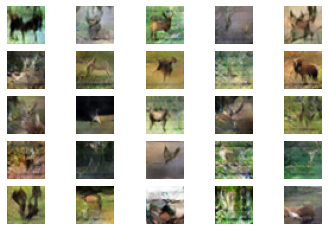

>171, 1/39, d1=0.435, d2=0.596 g=1.308
>171, 2/39, d1=0.453, d2=0.465 g=1.349
>171, 3/39, d1=0.498, d2=0.493 g=1.434
>171, 4/39, d1=0.486, d2=0.373 g=1.463
>171, 5/39, d1=0.406, d2=0.561 g=1.426
>171, 6/39, d1=0.475, d2=0.728 g=1.466
>171, 7/39, d1=0.480, d2=0.393 g=1.379
>171, 8/39, d1=0.540, d2=0.628 g=1.434
>171, 9/39, d1=0.578, d2=0.501 g=1.433
>171, 10/39, d1=0.684, d2=0.672 g=1.449
>171, 11/39, d1=0.600, d2=0.453 g=1.463
>171, 12/39, d1=0.624, d2=0.485 g=1.311
>171, 13/39, d1=0.497, d2=0.530 g=1.376
>171, 14/39, d1=0.461, d2=0.522 g=1.362
>171, 15/39, d1=0.673, d2=0.533 g=1.417
>171, 16/39, d1=0.591, d2=0.660 g=1.395
>171, 17/39, d1=0.648, d2=0.445 g=1.330
>171, 18/39, d1=0.572, d2=0.477 g=1.337
>171, 19/39, d1=0.527, d2=0.573 g=1.312
>171, 20/39, d1=0.519, d2=0.618 g=1.265
>171, 21/39, d1=0.525, d2=0.504 g=1.370
>171, 22/39, d1=0.536, d2=0.482 g=1.258
>171, 23/39, d1=0.583, d2=0.543 g=1.153
>171, 24/39, d1=0.474, d2=0.588 g=1.296
>171, 25/39, d1=0.586, d2=0.454 g=1.400
>171, 26/

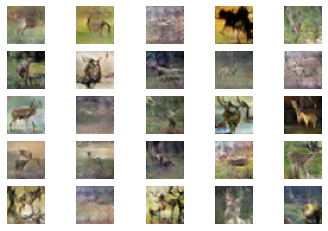

>176, 1/39, d1=0.409, d2=0.572 g=1.375
>176, 2/39, d1=0.369, d2=0.469 g=1.532
>176, 3/39, d1=0.516, d2=0.483 g=1.458
>176, 4/39, d1=0.481, d2=0.464 g=1.416
>176, 5/39, d1=0.491, d2=0.475 g=1.457
>176, 6/39, d1=0.481, d2=0.402 g=1.381
>176, 7/39, d1=0.481, d2=0.774 g=1.498
>176, 8/39, d1=0.524, d2=0.426 g=1.777
>176, 9/39, d1=0.703, d2=0.371 g=1.552
>176, 10/39, d1=0.586, d2=0.511 g=1.341
>176, 11/39, d1=0.435, d2=0.459 g=1.267
>176, 12/39, d1=0.460, d2=0.668 g=1.470
>176, 13/39, d1=0.522, d2=0.375 g=1.377
>176, 14/39, d1=0.516, d2=0.438 g=1.315
>176, 15/39, d1=0.471, d2=0.535 g=1.233
>176, 16/39, d1=0.471, d2=0.560 g=1.314
>176, 17/39, d1=0.451, d2=0.605 g=1.393
>176, 18/39, d1=0.475, d2=0.434 g=1.510
>176, 19/39, d1=0.626, d2=0.526 g=1.469
>176, 20/39, d1=0.499, d2=0.557 g=1.591
>176, 21/39, d1=0.590, d2=0.397 g=1.485
>176, 22/39, d1=0.543, d2=0.529 g=1.387
>176, 23/39, d1=0.648, d2=0.656 g=1.394
>176, 24/39, d1=0.583, d2=0.491 g=1.360
>176, 25/39, d1=0.672, d2=0.528 g=1.401
>176, 26/

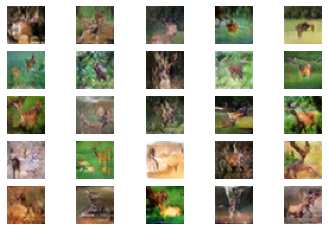

>181, 1/39, d1=0.403, d2=0.417 g=1.471
>181, 2/39, d1=0.589, d2=0.551 g=1.460
>181, 3/39, d1=0.566, d2=0.391 g=1.416
>181, 4/39, d1=0.520, d2=0.377 g=1.436
>181, 5/39, d1=0.524, d2=0.504 g=1.423
>181, 6/39, d1=0.434, d2=0.455 g=1.460
>181, 7/39, d1=0.420, d2=0.449 g=1.474
>181, 8/39, d1=0.324, d2=0.424 g=1.532
>181, 9/39, d1=0.589, d2=0.483 g=1.491
>181, 10/39, d1=0.605, d2=0.547 g=1.402
>181, 11/39, d1=0.600, d2=0.487 g=1.429
>181, 12/39, d1=0.438, d2=0.473 g=1.417
>181, 13/39, d1=0.484, d2=0.490 g=1.530
>181, 14/39, d1=0.585, d2=0.461 g=1.406
>181, 15/39, d1=0.523, d2=0.455 g=1.309
>181, 16/39, d1=0.549, d2=0.478 g=1.336
>181, 17/39, d1=0.486, d2=0.693 g=1.456
>181, 18/39, d1=0.519, d2=0.403 g=1.505
>181, 19/39, d1=0.497, d2=0.436 g=1.595
>181, 20/39, d1=0.386, d2=0.592 g=1.467
>181, 21/39, d1=0.628, d2=0.442 g=1.454
>181, 22/39, d1=0.534, d2=0.554 g=1.403
>181, 23/39, d1=0.643, d2=0.504 g=1.445
>181, 24/39, d1=0.630, d2=0.459 g=1.405
>181, 25/39, d1=0.560, d2=0.451 g=1.338
>181, 26/

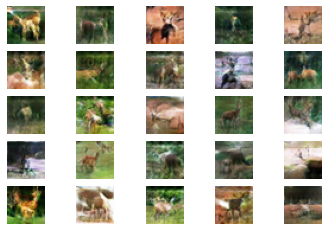

>186, 1/39, d1=0.413, d2=0.520 g=1.319
>186, 2/39, d1=0.423, d2=0.638 g=1.500
>186, 3/39, d1=0.581, d2=0.509 g=1.561
>186, 4/39, d1=0.529, d2=0.567 g=1.508
>186, 5/39, d1=0.590, d2=0.572 g=1.535
>186, 6/39, d1=0.575, d2=0.417 g=1.372
>186, 7/39, d1=0.480, d2=0.655 g=1.471
>186, 8/39, d1=0.423, d2=0.425 g=1.531
>186, 9/39, d1=0.619, d2=0.451 g=1.460
>186, 10/39, d1=0.686, d2=0.427 g=1.412
>186, 11/39, d1=0.484, d2=0.597 g=1.310
>186, 12/39, d1=0.523, d2=0.515 g=1.380
>186, 13/39, d1=0.469, d2=0.456 g=1.383
>186, 14/39, d1=0.531, d2=0.458 g=1.507
>186, 15/39, d1=0.502, d2=0.611 g=1.366
>186, 16/39, d1=0.609, d2=0.663 g=1.376
>186, 17/39, d1=0.554, d2=0.476 g=1.412
>186, 18/39, d1=0.654, d2=0.580 g=1.282
>186, 19/39, d1=0.556, d2=0.606 g=1.296
>186, 20/39, d1=0.521, d2=0.495 g=1.366
>186, 21/39, d1=0.562, d2=0.465 g=1.331
>186, 22/39, d1=0.522, d2=0.531 g=1.334
>186, 23/39, d1=0.476, d2=0.448 g=1.393
>186, 24/39, d1=0.468, d2=0.580 g=1.534
>186, 25/39, d1=0.447, d2=0.371 g=1.454
>186, 26/

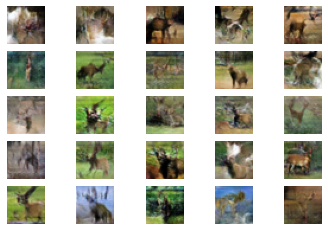

>191, 1/39, d1=0.373, d2=0.448 g=1.610
>191, 2/39, d1=0.481, d2=0.391 g=1.452
>191, 3/39, d1=0.627, d2=0.468 g=1.402
>191, 4/39, d1=0.520, d2=0.621 g=1.531
>191, 5/39, d1=0.585, d2=0.443 g=1.552
>191, 6/39, d1=0.659, d2=0.603 g=1.447
>191, 7/39, d1=0.486, d2=0.437 g=1.593
>191, 8/39, d1=0.513, d2=0.570 g=1.482
>191, 9/39, d1=0.384, d2=0.455 g=1.660
>191, 10/39, d1=0.575, d2=0.440 g=1.451
>191, 11/39, d1=0.441, d2=0.470 g=1.600
>191, 12/39, d1=0.530, d2=0.396 g=1.468
>191, 13/39, d1=0.469, d2=0.515 g=1.522
>191, 14/39, d1=0.386, d2=0.410 g=1.539
>191, 15/39, d1=0.532, d2=0.466 g=1.515
>191, 16/39, d1=0.531, d2=0.470 g=1.492
>191, 17/39, d1=0.636, d2=0.514 g=1.485
>191, 18/39, d1=0.432, d2=0.459 g=1.545
>191, 19/39, d1=0.587, d2=0.451 g=1.394
>191, 20/39, d1=0.521, d2=0.631 g=1.419
>191, 21/39, d1=0.509, d2=0.446 g=1.607
>191, 22/39, d1=0.593, d2=0.458 g=1.515
>191, 23/39, d1=0.565, d2=0.414 g=1.335
>191, 24/39, d1=0.517, d2=0.507 g=1.352
>191, 25/39, d1=0.393, d2=0.511 g=1.533
>191, 26/

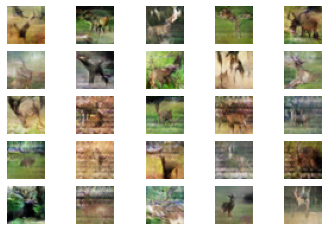

>196, 1/39, d1=0.369, d2=0.522 g=1.448
>196, 2/39, d1=0.560, d2=0.424 g=1.354
>196, 3/39, d1=0.438, d2=0.548 g=1.445
>196, 4/39, d1=0.438, d2=0.531 g=1.517
>196, 5/39, d1=0.476, d2=0.509 g=1.549
>196, 6/39, d1=0.595, d2=0.476 g=1.518
>196, 7/39, d1=0.593, d2=0.432 g=1.534
>196, 8/39, d1=0.509, d2=0.465 g=1.525
>196, 9/39, d1=0.538, d2=0.555 g=1.595
>196, 10/39, d1=0.728, d2=0.432 g=1.461
>196, 11/39, d1=0.414, d2=0.665 g=1.546
>196, 12/39, d1=0.462, d2=0.423 g=1.492
>196, 13/39, d1=0.579, d2=0.564 g=1.546
>196, 14/39, d1=0.650, d2=0.456 g=1.522
>196, 15/39, d1=0.539, d2=0.427 g=1.475
>196, 16/39, d1=0.443, d2=0.555 g=1.601
>196, 17/39, d1=0.492, d2=0.392 g=1.585
>196, 18/39, d1=0.387, d2=0.380 g=1.621
>196, 19/39, d1=0.417, d2=0.398 g=1.541
>196, 20/39, d1=0.443, d2=0.576 g=1.489
>196, 21/39, d1=0.515, d2=0.399 g=1.632
>196, 22/39, d1=0.509, d2=0.580 g=1.535
>196, 23/39, d1=0.581, d2=0.377 g=1.480
>196, 24/39, d1=0.440, d2=0.372 g=1.570
>196, 25/39, d1=0.501, d2=0.635 g=1.532
>196, 26/

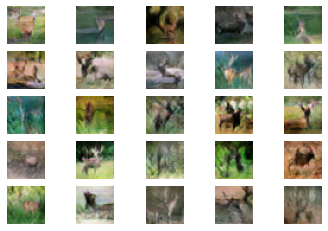

>201, 1/39, d1=0.334, d2=0.401 g=1.712
>201, 2/39, d1=0.439, d2=0.472 g=1.657
>201, 3/39, d1=0.554, d2=0.583 g=1.567
>201, 4/39, d1=0.494, d2=0.510 g=1.583
>201, 5/39, d1=0.566, d2=0.465 g=1.501
>201, 6/39, d1=0.563, d2=0.409 g=1.450
>201, 7/39, d1=0.470, d2=0.591 g=1.564
>201, 8/39, d1=0.527, d2=0.402 g=1.641
>201, 9/39, d1=0.421, d2=0.440 g=1.430
>201, 10/39, d1=0.367, d2=0.542 g=1.699
>201, 11/39, d1=0.565, d2=0.375 g=1.596
>201, 12/39, d1=0.579, d2=0.344 g=1.532
>201, 13/39, d1=0.391, d2=0.614 g=1.559
>201, 14/39, d1=0.486, d2=0.443 g=1.518
>201, 15/39, d1=0.642, d2=0.446 g=1.714
>201, 16/39, d1=0.439, d2=0.414 g=1.710
>201, 17/39, d1=0.447, d2=0.478 g=1.672
>201, 18/39, d1=0.639, d2=0.488 g=1.514
>201, 19/39, d1=0.370, d2=0.402 g=1.493
>201, 20/39, d1=0.420, d2=0.480 g=1.608
>201, 21/39, d1=0.408, d2=0.379 g=1.605
>201, 22/39, d1=0.548, d2=0.490 g=1.450
>201, 23/39, d1=0.523, d2=0.655 g=1.707
>201, 24/39, d1=0.515, d2=0.427 g=1.629
>201, 25/39, d1=0.621, d2=0.439 g=1.635
>201, 26/

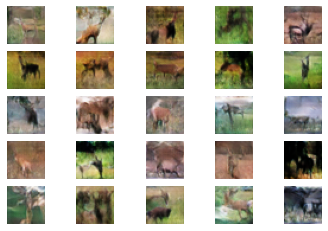

>206, 1/39, d1=0.401, d2=0.641 g=1.618
>206, 2/39, d1=0.648, d2=0.390 g=1.529
>206, 3/39, d1=0.556, d2=0.494 g=1.475
>206, 4/39, d1=0.574, d2=0.637 g=1.515
>206, 5/39, d1=0.538, d2=0.471 g=1.422
>206, 6/39, d1=0.330, d2=0.544 g=1.520
>206, 7/39, d1=0.499, d2=0.382 g=1.677
>206, 8/39, d1=0.473, d2=0.524 g=1.644
>206, 9/39, d1=0.450, d2=0.544 g=1.746
>206, 10/39, d1=0.524, d2=0.320 g=1.564
>206, 11/39, d1=0.479, d2=0.518 g=1.663
>206, 12/39, d1=0.510, d2=0.461 g=1.450
>206, 13/39, d1=0.457, d2=0.514 g=1.567
>206, 14/39, d1=0.343, d2=0.561 g=1.861
>206, 15/39, d1=0.676, d2=0.273 g=1.566
>206, 16/39, d1=0.527, d2=0.431 g=1.461
>206, 17/39, d1=0.409, d2=0.582 g=1.660
>206, 18/39, d1=0.486, d2=0.495 g=1.717
>206, 19/39, d1=0.480, d2=0.380 g=1.613
>206, 20/39, d1=0.561, d2=0.484 g=1.648
>206, 21/39, d1=0.534, d2=0.419 g=1.557
>206, 22/39, d1=0.571, d2=0.540 g=1.634
>206, 23/39, d1=0.387, d2=0.498 g=1.767
>206, 24/39, d1=0.476, d2=0.307 g=1.745
>206, 25/39, d1=0.469, d2=0.577 g=1.769
>206, 26/

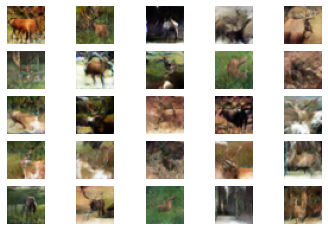

>211, 1/39, d1=0.337, d2=0.399 g=1.687
>211, 2/39, d1=0.387, d2=0.484 g=1.670
>211, 3/39, d1=0.458, d2=0.566 g=1.745
>211, 4/39, d1=0.523, d2=0.332 g=1.612
>211, 5/39, d1=0.387, d2=0.556 g=1.688
>211, 6/39, d1=0.450, d2=0.412 g=1.626
>211, 7/39, d1=0.387, d2=0.413 g=1.723
>211, 8/39, d1=0.368, d2=0.425 g=1.918
>211, 9/39, d1=0.568, d2=0.443 g=1.988
>211, 10/39, d1=0.565, d2=0.403 g=1.784
>211, 11/39, d1=0.374, d2=0.507 g=1.893
>211, 12/39, d1=0.486, d2=0.365 g=1.752
>211, 13/39, d1=0.571, d2=0.353 g=1.630
>211, 14/39, d1=0.376, d2=0.388 g=1.684
>211, 15/39, d1=0.470, d2=0.398 g=1.703
>211, 16/39, d1=0.359, d2=0.408 g=1.785
>211, 17/39, d1=0.379, d2=0.551 g=1.841
>211, 18/39, d1=0.514, d2=0.428 g=1.779
>211, 19/39, d1=0.555, d2=0.462 g=1.890
>211, 20/39, d1=0.331, d2=0.506 g=1.893
>211, 21/39, d1=0.514, d2=0.347 g=1.620
>211, 22/39, d1=0.590, d2=0.527 g=1.777
>211, 23/39, d1=0.502, d2=0.449 g=1.671
>211, 24/39, d1=0.505, d2=0.466 g=1.573
>211, 25/39, d1=0.390, d2=0.497 g=1.748
>211, 26/

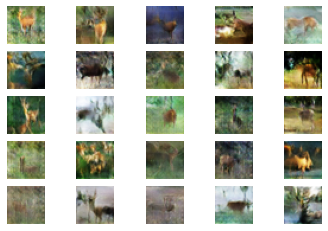

>216, 1/39, d1=0.339, d2=0.477 g=1.663
>216, 2/39, d1=0.584, d2=0.351 g=1.720
>216, 3/39, d1=0.498, d2=0.426 g=1.516
>216, 4/39, d1=0.374, d2=0.469 g=1.605
>216, 5/39, d1=0.373, d2=0.400 g=1.578
>216, 6/39, d1=0.462, d2=0.492 g=1.652
>216, 7/39, d1=0.474, d2=0.517 g=1.761
>216, 8/39, d1=0.388, d2=0.428 g=1.586
>216, 9/39, d1=0.483, d2=0.528 g=1.675
>216, 10/39, d1=0.635, d2=0.490 g=1.614
>216, 11/39, d1=0.541, d2=0.472 g=1.897
>216, 12/39, d1=0.527, d2=0.341 g=1.861
>216, 13/39, d1=0.565, d2=0.421 g=1.545
>216, 14/39, d1=0.396, d2=0.679 g=1.666
>216, 15/39, d1=0.551, d2=0.435 g=1.682
>216, 16/39, d1=0.495, d2=0.390 g=1.745
>216, 17/39, d1=0.534, d2=0.600 g=1.691
>216, 18/39, d1=0.484, d2=0.375 g=1.755
>216, 19/39, d1=0.574, d2=0.322 g=1.638
>216, 20/39, d1=0.431, d2=0.520 g=1.632
>216, 21/39, d1=0.408, d2=0.403 g=1.617
>216, 22/39, d1=0.446, d2=0.520 g=1.619
>216, 23/39, d1=0.338, d2=0.377 g=1.639
>216, 24/39, d1=0.400, d2=0.452 g=1.658
>216, 25/39, d1=0.379, d2=0.400 g=1.698
>216, 26/

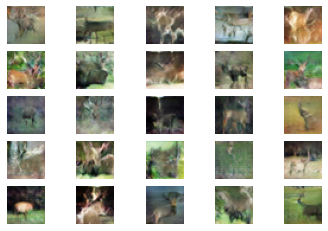

>221, 1/39, d1=0.297, d2=0.544 g=1.986
>221, 2/39, d1=0.455, d2=0.426 g=1.778
>221, 3/39, d1=0.748, d2=0.513 g=1.647
>221, 4/39, d1=0.437, d2=0.371 g=1.727
>221, 5/39, d1=0.429, d2=0.459 g=1.728
>221, 6/39, d1=0.379, d2=0.497 g=1.738
>221, 7/39, d1=0.361, d2=0.590 g=1.845
>221, 8/39, d1=0.619, d2=0.408 g=1.681
>221, 9/39, d1=0.439, d2=0.341 g=1.708
>221, 10/39, d1=0.532, d2=0.453 g=1.526
>221, 11/39, d1=0.539, d2=0.577 g=1.552
>221, 12/39, d1=0.456, d2=0.474 g=1.827
>221, 13/39, d1=0.514, d2=0.439 g=1.782
>221, 14/39, d1=0.480, d2=0.405 g=1.683
>221, 15/39, d1=0.433, d2=0.505 g=1.641
>221, 16/39, d1=0.491, d2=0.555 g=1.759
>221, 17/39, d1=0.513, d2=0.470 g=1.622
>221, 18/39, d1=0.559, d2=0.322 g=1.590
>221, 19/39, d1=0.363, d2=0.519 g=1.679
>221, 20/39, d1=0.409, d2=0.367 g=1.734
>221, 21/39, d1=0.408, d2=0.398 g=1.907
>221, 22/39, d1=0.419, d2=0.412 g=1.890
>221, 23/39, d1=0.512, d2=0.591 g=1.934
>221, 24/39, d1=0.629, d2=0.356 g=1.752
>221, 25/39, d1=0.525, d2=0.464 g=1.820
>221, 26/

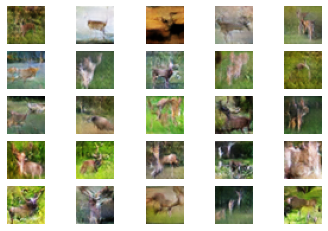

>226, 1/39, d1=0.374, d2=0.444 g=1.892
>226, 2/39, d1=0.507, d2=0.646 g=1.781
>226, 3/39, d1=0.444, d2=0.433 g=1.725
>226, 4/39, d1=0.502, d2=0.608 g=1.678
>226, 5/39, d1=0.506, d2=0.410 g=1.579
>226, 6/39, d1=0.492, d2=0.460 g=1.670
>226, 7/39, d1=0.429, d2=0.601 g=1.502
>226, 8/39, d1=0.431, d2=0.347 g=1.694
>226, 9/39, d1=0.384, d2=0.489 g=1.682
>226, 10/39, d1=0.623, d2=0.384 g=1.560
>226, 11/39, d1=0.511, d2=0.660 g=1.627
>226, 12/39, d1=0.501, d2=0.493 g=1.768
>226, 13/39, d1=0.459, d2=0.305 g=1.865
>226, 14/39, d1=0.356, d2=0.451 g=1.866
>226, 15/39, d1=0.466, d2=0.528 g=1.820
>226, 16/39, d1=0.379, d2=0.441 g=1.788
>226, 17/39, d1=0.657, d2=0.330 g=1.690
>226, 18/39, d1=0.484, d2=0.384 g=1.563
>226, 19/39, d1=0.456, d2=0.651 g=1.680
>226, 20/39, d1=0.421, d2=0.394 g=1.865
>226, 21/39, d1=0.481, d2=0.368 g=1.673
>226, 22/39, d1=0.287, d2=0.476 g=1.845
>226, 23/39, d1=0.515, d2=0.359 g=1.769
>226, 24/39, d1=0.428, d2=0.456 g=1.854
>226, 25/39, d1=0.472, d2=0.504 g=1.914
>226, 26/

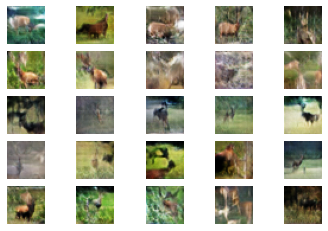

>231, 1/39, d1=0.349, d2=0.575 g=1.947
>231, 2/39, d1=0.544, d2=0.448 g=2.010
>231, 3/39, d1=0.473, d2=0.371 g=1.732
>231, 4/39, d1=0.464, d2=0.499 g=1.897
>231, 5/39, d1=0.400, d2=0.301 g=1.695
>231, 6/39, d1=0.540, d2=0.517 g=1.816
>231, 7/39, d1=0.445, d2=0.477 g=1.954
>231, 8/39, d1=0.486, d2=0.416 g=2.209
>231, 9/39, d1=0.623, d2=0.424 g=1.959
>231, 10/39, d1=0.369, d2=0.439 g=1.730
>231, 11/39, d1=0.394, d2=0.363 g=1.659
>231, 12/39, d1=0.326, d2=0.336 g=1.836
>231, 13/39, d1=0.467, d2=0.693 g=1.938
>231, 14/39, d1=0.334, d2=0.382 g=1.958
>231, 15/39, d1=0.511, d2=0.407 g=1.810
>231, 16/39, d1=0.375, d2=0.418 g=1.839
>231, 17/39, d1=0.434, d2=0.514 g=2.044
>231, 18/39, d1=0.553, d2=0.321 g=1.990
>231, 19/39, d1=0.497, d2=0.316 g=1.744
>231, 20/39, d1=0.417, d2=0.664 g=2.080
>231, 21/39, d1=0.567, d2=0.352 g=1.867
>231, 22/39, d1=0.586, d2=0.340 g=1.669
>231, 23/39, d1=0.323, d2=0.673 g=2.038
>231, 24/39, d1=0.497, d2=0.252 g=1.790
>231, 25/39, d1=0.445, d2=0.412 g=1.615
>231, 26/

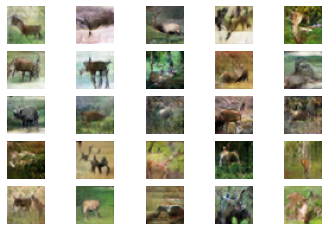

>236, 1/39, d1=0.327, d2=0.532 g=1.961
>236, 2/39, d1=0.464, d2=0.468 g=1.984
>236, 3/39, d1=0.510, d2=0.395 g=1.808
>236, 4/39, d1=0.464, d2=0.432 g=1.704
>236, 5/39, d1=0.579, d2=0.561 g=1.752
>236, 6/39, d1=0.477, d2=0.475 g=1.634
>236, 7/39, d1=0.500, d2=0.489 g=1.677
>236, 8/39, d1=0.464, d2=0.447 g=1.701
>236, 9/39, d1=0.500, d2=0.353 g=1.661
>236, 10/39, d1=0.442, d2=0.471 g=1.652
>236, 11/39, d1=0.381, d2=0.388 g=1.546
>236, 12/39, d1=0.348, d2=0.496 g=1.806
>236, 13/39, d1=0.441, d2=0.424 g=1.808
>236, 14/39, d1=0.486, d2=0.437 g=1.917
>236, 15/39, d1=0.506, d2=0.463 g=1.838
>236, 16/39, d1=0.527, d2=0.404 g=1.746
>236, 17/39, d1=0.621, d2=0.516 g=1.759
>236, 18/39, d1=0.491, d2=0.361 g=1.678
>236, 19/39, d1=0.436, d2=0.452 g=1.784
>236, 20/39, d1=0.445, d2=0.382 g=1.958
>236, 21/39, d1=0.375, d2=0.335 g=2.013
>236, 22/39, d1=0.419, d2=0.394 g=2.063
>236, 23/39, d1=0.452, d2=0.391 g=1.901
>236, 24/39, d1=0.480, d2=0.441 g=1.742
>236, 25/39, d1=0.521, d2=0.480 g=1.839
>236, 26/

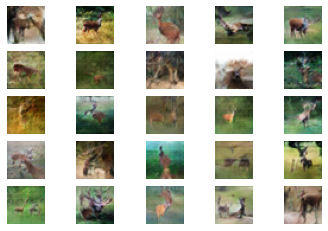

>241, 1/39, d1=0.302, d2=0.408 g=1.882
>241, 2/39, d1=0.517, d2=0.378 g=1.881
>241, 3/39, d1=0.510, d2=0.404 g=1.569
>241, 4/39, d1=0.272, d2=0.525 g=1.711
>241, 5/39, d1=0.390, d2=0.361 g=1.808
>241, 6/39, d1=0.422, d2=0.591 g=2.132
>241, 7/39, d1=0.497, d2=0.299 g=1.915
>241, 8/39, d1=0.417, d2=0.366 g=1.769
>241, 9/39, d1=0.442, d2=0.428 g=1.729
>241, 10/39, d1=0.349, d2=0.411 g=1.938
>241, 11/39, d1=0.442, d2=0.525 g=1.957
>241, 12/39, d1=0.426, d2=0.279 g=1.985
>241, 13/39, d1=0.541, d2=0.452 g=1.723
>241, 14/39, d1=0.345, d2=0.313 g=1.945
>241, 15/39, d1=0.322, d2=0.490 g=2.088
>241, 16/39, d1=0.516, d2=0.300 g=2.145
>241, 17/39, d1=0.348, d2=0.395 g=2.018
>241, 18/39, d1=0.274, d2=0.422 g=2.327
>241, 19/39, d1=0.312, d2=0.261 g=2.177
>241, 20/39, d1=0.373, d2=0.429 g=2.322
>241, 21/39, d1=0.469, d2=0.319 g=1.746
>241, 22/39, d1=0.384, d2=0.406 g=1.871
>241, 23/39, d1=0.370, d2=0.561 g=1.985
>241, 24/39, d1=0.413, d2=0.391 g=1.954
>241, 25/39, d1=0.610, d2=0.357 g=1.771
>241, 26/

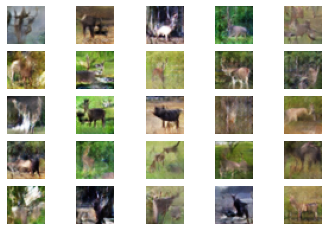

>246, 1/39, d1=0.276, d2=0.250 g=1.900
>246, 2/39, d1=0.554, d2=0.348 g=1.740
>246, 3/39, d1=0.343, d2=0.743 g=1.834
>246, 4/39, d1=0.345, d2=0.414 g=2.131
>246, 5/39, d1=0.559, d2=0.371 g=1.947
>246, 6/39, d1=0.406, d2=0.394 g=1.954
>246, 7/39, d1=0.445, d2=0.498 g=1.978
>246, 8/39, d1=0.457, d2=0.383 g=2.005
>246, 9/39, d1=0.452, d2=0.422 g=2.118
>246, 10/39, d1=0.471, d2=0.360 g=2.048
>246, 11/39, d1=0.553, d2=0.354 g=1.717
>246, 12/39, d1=0.436, d2=0.443 g=1.915
>246, 13/39, d1=0.343, d2=0.469 g=2.039
>246, 14/39, d1=0.426, d2=0.382 g=1.885
>246, 15/39, d1=0.524, d2=0.278 g=1.797
>246, 16/39, d1=0.407, d2=0.495 g=1.934
>246, 17/39, d1=0.391, d2=0.396 g=1.930
>246, 18/39, d1=0.356, d2=0.473 g=2.115
>246, 19/39, d1=0.573, d2=0.423 g=1.969
>246, 20/39, d1=0.462, d2=0.408 g=1.949
>246, 21/39, d1=0.343, d2=0.430 g=2.127
>246, 22/39, d1=0.431, d2=0.287 g=1.984
>246, 23/39, d1=0.381, d2=0.355 g=1.914
>246, 24/39, d1=0.363, d2=0.299 g=2.103
>246, 25/39, d1=0.410, d2=0.479 g=2.025
>246, 26/

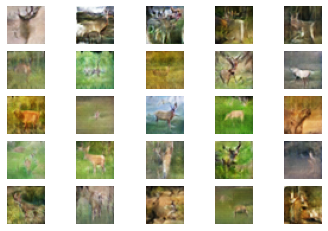

>251, 1/39, d1=0.282, d2=0.414 g=2.050
>251, 2/39, d1=0.275, d2=0.363 g=2.064
>251, 3/39, d1=0.498, d2=0.378 g=2.011
>251, 4/39, d1=0.264, d2=0.498 g=2.384
>251, 5/39, d1=0.450, d2=0.323 g=2.330
>251, 6/39, d1=0.424, d2=0.316 g=2.102
>251, 7/39, d1=0.553, d2=0.328 g=1.940
>251, 8/39, d1=0.406, d2=0.512 g=1.899
>251, 9/39, d1=0.450, d2=0.395 g=2.110
>251, 10/39, d1=0.359, d2=0.330 g=2.181
>251, 11/39, d1=0.377, d2=0.356 g=1.919
>251, 12/39, d1=0.382, d2=0.482 g=1.975
>251, 13/39, d1=0.425, d2=0.403 g=1.977
>251, 14/39, d1=0.620, d2=0.422 g=2.086
>251, 15/39, d1=0.277, d2=0.308 g=1.889
>251, 16/39, d1=0.323, d2=0.407 g=2.088
>251, 17/39, d1=0.453, d2=0.540 g=2.214
>251, 18/39, d1=0.486, d2=0.305 g=2.170
>251, 19/39, d1=0.356, d2=0.345 g=2.132
>251, 20/39, d1=0.344, d2=0.249 g=2.015
>251, 21/39, d1=0.398, d2=0.407 g=1.997
>251, 22/39, d1=0.500, d2=0.393 g=2.251
>251, 23/39, d1=0.475, d2=0.297 g=2.050
>251, 24/39, d1=0.321, d2=0.377 g=1.718
>251, 25/39, d1=0.296, d2=0.484 g=1.874
>251, 26/

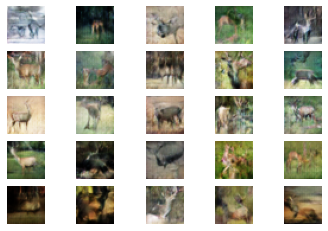

>256, 1/39, d1=0.277, d2=0.358 g=1.990
>256, 2/39, d1=0.246, d2=0.356 g=1.922
>256, 3/39, d1=0.449, d2=0.567 g=2.158
>256, 4/39, d1=0.487, d2=0.386 g=2.072
>256, 5/39, d1=0.477, d2=0.331 g=2.050
>256, 6/39, d1=0.249, d2=0.425 g=2.153
>256, 7/39, d1=0.430, d2=0.285 g=2.074
>256, 8/39, d1=0.412, d2=0.308 g=2.056
>256, 9/39, d1=0.343, d2=0.476 g=2.063
>256, 10/39, d1=0.405, d2=0.461 g=2.160
>256, 11/39, d1=0.415, d2=0.416 g=2.208
>256, 12/39, d1=0.443, d2=0.437 g=2.259
>256, 13/39, d1=0.308, d2=0.275 g=2.357
>256, 14/39, d1=0.590, d2=0.301 g=2.012
>256, 15/39, d1=0.408, d2=0.417 g=1.875
>256, 16/39, d1=0.455, d2=0.490 g=2.100
>256, 17/39, d1=0.390, d2=0.473 g=2.100
>256, 18/39, d1=0.385, d2=0.291 g=2.267
>256, 19/39, d1=0.426, d2=0.432 g=2.271
>256, 20/39, d1=0.525, d2=0.313 g=2.130
>256, 21/39, d1=0.435, d2=0.680 g=2.288
>256, 22/39, d1=0.376, d2=0.332 g=2.343
>256, 23/39, d1=0.589, d2=0.320 g=2.152
>256, 24/39, d1=0.430, d2=0.391 g=1.977
>256, 25/39, d1=0.308, d2=0.402 g=2.011
>256, 26/

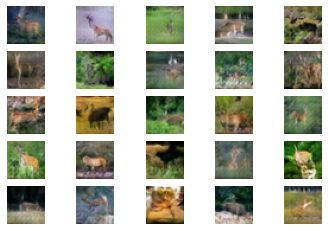

>261, 1/39, d1=0.308, d2=0.394 g=2.123
>261, 2/39, d1=0.319, d2=0.369 g=2.456
>261, 3/39, d1=0.381, d2=0.259 g=2.105
>261, 4/39, d1=0.276, d2=0.392 g=2.312
>261, 5/39, d1=0.296, d2=0.346 g=2.472
>261, 6/39, d1=0.565, d2=0.246 g=2.158
>261, 7/39, d1=0.352, d2=0.514 g=2.124
>261, 8/39, d1=0.393, d2=0.247 g=1.966
>261, 9/39, d1=0.464, d2=0.382 g=2.029
>261, 10/39, d1=0.311, d2=0.403 g=2.036
>261, 11/39, d1=0.347, d2=0.277 g=2.104
>261, 12/39, d1=0.438, d2=0.330 g=1.942
>261, 13/39, d1=0.276, d2=0.358 g=2.257
>261, 14/39, d1=0.531, d2=0.427 g=2.128
>261, 15/39, d1=0.329, d2=0.362 g=2.242
>261, 16/39, d1=0.375, d2=0.551 g=2.315
>261, 17/39, d1=0.517, d2=0.311 g=2.145
>261, 18/39, d1=0.404, d2=0.485 g=2.087
>261, 19/39, d1=0.408, d2=0.327 g=2.263
>261, 20/39, d1=0.419, d2=0.305 g=2.141
>261, 21/39, d1=0.486, d2=0.444 g=2.283
>261, 22/39, d1=0.431, d2=0.346 g=2.074
>261, 23/39, d1=0.278, d2=0.294 g=2.144
>261, 24/39, d1=0.326, d2=0.467 g=2.179
>261, 25/39, d1=0.430, d2=0.457 g=2.242
>261, 26/

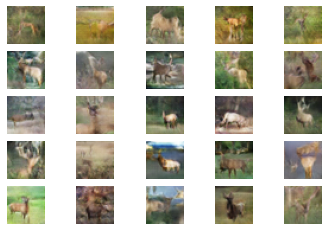

>266, 1/39, d1=0.216, d2=0.386 g=2.407
>266, 2/39, d1=0.588, d2=0.255 g=2.227
>266, 3/39, d1=0.365, d2=0.520 g=2.296
>266, 4/39, d1=0.464, d2=0.390 g=2.031
>266, 5/39, d1=0.418, d2=0.410 g=2.265
>266, 6/39, d1=0.399, d2=0.301 g=2.272
>266, 7/39, d1=0.476, d2=0.396 g=1.834
>266, 8/39, d1=0.318, d2=0.345 g=1.977
>266, 9/39, d1=0.424, d2=0.557 g=2.199
>266, 10/39, d1=0.407, d2=0.358 g=2.176
>266, 11/39, d1=0.443, d2=0.326 g=2.076
>266, 12/39, d1=0.284, d2=0.401 g=2.230
>266, 13/39, d1=0.543, d2=0.353 g=1.807
>266, 14/39, d1=0.450, d2=0.370 g=2.151
>266, 15/39, d1=0.391, d2=0.483 g=1.988
>266, 16/39, d1=0.250, d2=0.654 g=2.133
>266, 17/39, d1=0.453, d2=0.421 g=2.094
>266, 18/39, d1=0.454, d2=0.449 g=2.174
>266, 19/39, d1=0.459, d2=0.411 g=2.147
>266, 20/39, d1=0.406, d2=0.364 g=2.170
>266, 21/39, d1=0.279, d2=0.349 g=2.146
>266, 22/39, d1=0.381, d2=0.253 g=2.322
>266, 23/39, d1=0.431, d2=0.404 g=2.376
>266, 24/39, d1=0.415, d2=0.374 g=2.260
>266, 25/39, d1=0.302, d2=0.364 g=2.239
>266, 26/

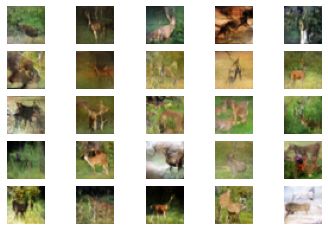

>271, 1/39, d1=0.260, d2=0.332 g=2.183
>271, 2/39, d1=0.415, d2=0.332 g=1.998
>271, 3/39, d1=0.272, d2=0.358 g=2.232
>271, 4/39, d1=0.333, d2=0.430 g=2.508
>271, 5/39, d1=0.417, d2=0.245 g=2.194
>271, 6/39, d1=0.317, d2=0.286 g=2.116
>271, 7/39, d1=0.319, d2=0.587 g=2.174
>271, 8/39, d1=0.357, d2=0.420 g=2.461
>271, 9/39, d1=0.469, d2=0.238 g=2.426
>271, 10/39, d1=0.381, d2=0.610 g=2.410
>271, 11/39, d1=0.349, d2=0.270 g=2.380
>271, 12/39, d1=0.332, d2=0.241 g=2.371
>271, 13/39, d1=0.498, d2=0.521 g=2.274
>271, 14/39, d1=0.391, d2=0.653 g=2.421
>271, 15/39, d1=0.509, d2=0.291 g=2.406
>271, 16/39, d1=0.425, d2=0.416 g=2.226
>271, 17/39, d1=0.579, d2=0.391 g=1.780
>271, 18/39, d1=0.341, d2=0.523 g=1.980
>271, 19/39, d1=0.401, d2=0.516 g=2.158
>271, 20/39, d1=0.469, d2=0.466 g=2.137
>271, 21/39, d1=0.591, d2=0.385 g=2.106
>271, 22/39, d1=0.354, d2=0.345 g=2.006
>271, 23/39, d1=0.231, d2=0.289 g=2.299
>271, 24/39, d1=0.343, d2=0.359 g=2.152
>271, 25/39, d1=0.488, d2=0.422 g=2.331
>271, 26/

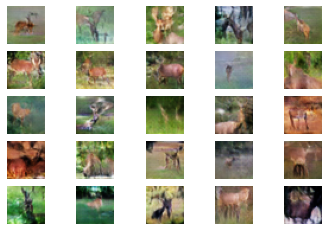

>276, 1/39, d1=0.245, d2=0.255 g=2.470
>276, 2/39, d1=0.569, d2=0.592 g=2.204
>276, 3/39, d1=0.413, d2=0.433 g=2.505
>276, 4/39, d1=0.419, d2=0.331 g=2.206
>276, 5/39, d1=0.494, d2=0.360 g=2.133
>276, 6/39, d1=0.280, d2=0.434 g=2.271
>276, 7/39, d1=0.381, d2=0.457 g=2.413
>276, 8/39, d1=0.368, d2=0.339 g=2.609
>276, 9/39, d1=0.418, d2=0.324 g=2.441
>276, 10/39, d1=0.411, d2=0.477 g=2.212
>276, 11/39, d1=0.429, d2=0.357 g=2.311
>276, 12/39, d1=0.419, d2=0.414 g=2.192
>276, 13/39, d1=0.282, d2=0.392 g=2.197
>276, 14/39, d1=0.415, d2=0.416 g=2.215
>276, 15/39, d1=0.408, d2=0.245 g=2.487
>276, 16/39, d1=0.523, d2=0.444 g=2.121
>276, 17/39, d1=0.375, d2=0.309 g=1.990
>276, 18/39, d1=0.307, d2=0.412 g=2.453
>276, 19/39, d1=0.375, d2=0.357 g=2.469
>276, 20/39, d1=0.322, d2=0.273 g=2.387
>276, 21/39, d1=0.578, d2=0.311 g=2.188
>276, 22/39, d1=0.501, d2=0.392 g=1.846
>276, 23/39, d1=0.336, d2=0.364 g=1.923
>276, 24/39, d1=0.341, d2=0.336 g=1.979
>276, 25/39, d1=0.343, d2=0.397 g=2.289
>276, 26/

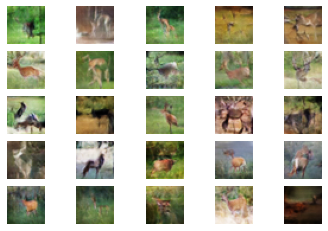

>281, 1/39, d1=0.296, d2=0.408 g=2.152
>281, 2/39, d1=0.368, d2=0.318 g=2.142
>281, 3/39, d1=0.481, d2=0.437 g=2.276
>281, 4/39, d1=0.266, d2=0.318 g=2.120
>281, 5/39, d1=0.340, d2=0.390 g=2.180
>281, 6/39, d1=0.400, d2=0.330 g=2.124
>281, 7/39, d1=0.276, d2=0.589 g=2.439
>281, 8/39, d1=0.391, d2=0.321 g=2.248
>281, 9/39, d1=0.345, d2=0.305 g=2.365
>281, 10/39, d1=0.373, d2=0.360 g=2.093
>281, 11/39, d1=0.375, d2=0.381 g=2.062
>281, 12/39, d1=0.334, d2=0.441 g=2.249
>281, 13/39, d1=0.384, d2=0.300 g=2.317
>281, 14/39, d1=0.451, d2=0.363 g=2.274
>281, 15/39, d1=0.295, d2=0.402 g=2.328
>281, 16/39, d1=0.440, d2=0.322 g=2.386
>281, 17/39, d1=0.453, d2=0.243 g=2.467
>281, 18/39, d1=0.295, d2=0.476 g=2.319
>281, 19/39, d1=0.473, d2=0.526 g=2.595
>281, 20/39, d1=0.292, d2=0.306 g=2.402
>281, 21/39, d1=0.385, d2=0.259 g=2.117
>281, 22/39, d1=0.364, d2=0.415 g=2.428
>281, 23/39, d1=0.374, d2=0.262 g=2.333
>281, 24/39, d1=0.346, d2=0.227 g=2.140
>281, 25/39, d1=0.262, d2=0.467 g=2.228
>281, 26/

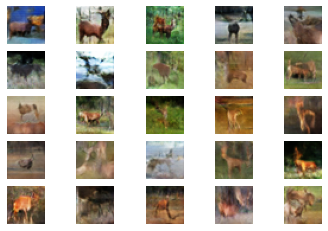

>286, 1/39, d1=0.254, d2=0.204 g=2.563
>286, 2/39, d1=0.449, d2=0.503 g=2.458
>286, 3/39, d1=0.453, d2=0.323 g=2.233
>286, 4/39, d1=0.304, d2=0.437 g=2.309
>286, 5/39, d1=0.405, d2=0.252 g=2.172
>286, 6/39, d1=0.367, d2=0.364 g=2.243
>286, 7/39, d1=0.247, d2=0.252 g=2.122
>286, 8/39, d1=0.316, d2=0.415 g=2.300
>286, 9/39, d1=0.459, d2=0.365 g=2.080
>286, 10/39, d1=0.258, d2=0.341 g=2.518
>286, 11/39, d1=0.514, d2=0.298 g=2.842
>286, 12/39, d1=0.404, d2=0.479 g=2.436
>286, 13/39, d1=0.441, d2=0.307 g=2.318
>286, 14/39, d1=0.225, d2=0.293 g=2.162
>286, 15/39, d1=0.224, d2=0.414 g=2.217
>286, 16/39, d1=0.286, d2=0.374 g=2.328
>286, 17/39, d1=0.346, d2=0.420 g=2.374
>286, 18/39, d1=0.417, d2=0.526 g=2.655
>286, 19/39, d1=0.467, d2=0.330 g=2.682
>286, 20/39, d1=0.447, d2=0.327 g=2.470
>286, 21/39, d1=0.338, d2=0.321 g=2.632
>286, 22/39, d1=0.396, d2=0.206 g=2.513
>286, 23/39, d1=0.335, d2=0.507 g=2.596
>286, 24/39, d1=0.340, d2=0.381 g=2.650
>286, 25/39, d1=0.387, d2=0.403 g=2.906
>286, 26/

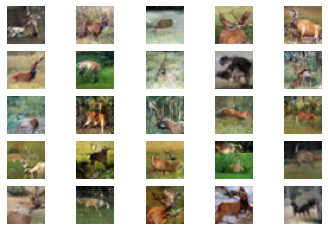

>291, 1/39, d1=0.274, d2=0.514 g=2.538
>291, 2/39, d1=0.486, d2=0.331 g=2.351
>291, 3/39, d1=0.330, d2=0.378 g=2.229
>291, 4/39, d1=0.302, d2=0.336 g=2.516
>291, 5/39, d1=0.421, d2=0.501 g=2.317
>291, 6/39, d1=0.506, d2=0.317 g=2.266
>291, 7/39, d1=0.409, d2=0.458 g=2.274
>291, 8/39, d1=0.385, d2=0.450 g=2.483
>291, 9/39, d1=0.360, d2=0.279 g=2.284
>291, 10/39, d1=0.356, d2=0.405 g=2.425
>291, 11/39, d1=0.323, d2=0.226 g=2.261
>291, 12/39, d1=0.301, d2=0.412 g=2.273
>291, 13/39, d1=0.314, d2=0.448 g=2.459
>291, 14/39, d1=0.495, d2=0.346 g=2.442
>291, 15/39, d1=0.305, d2=0.328 g=2.358
>291, 16/39, d1=0.355, d2=0.228 g=2.134
>291, 17/39, d1=0.397, d2=0.468 g=2.274
>291, 18/39, d1=0.407, d2=0.344 g=2.357
>291, 19/39, d1=0.270, d2=0.349 g=2.534
>291, 20/39, d1=0.411, d2=0.327 g=2.411
>291, 21/39, d1=0.414, d2=0.262 g=2.441
>291, 22/39, d1=0.337, d2=0.370 g=2.595
>291, 23/39, d1=0.340, d2=0.311 g=2.438
>291, 24/39, d1=0.400, d2=0.420 g=2.276
>291, 25/39, d1=0.321, d2=0.341 g=2.133
>291, 26/

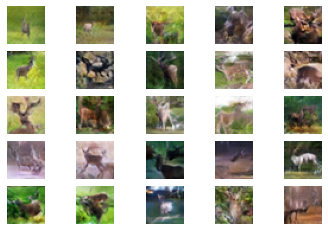

>296, 1/39, d1=0.232, d2=0.355 g=2.654
>296, 2/39, d1=0.321, d2=0.295 g=2.631
>296, 3/39, d1=0.462, d2=0.296 g=2.295
>296, 4/39, d1=0.400, d2=0.597 g=2.547
>296, 5/39, d1=0.340, d2=0.340 g=2.609
>296, 6/39, d1=0.428, d2=0.286 g=2.409
>296, 7/39, d1=0.375, d2=0.365 g=2.319
>296, 8/39, d1=0.334, d2=0.450 g=2.574
>296, 9/39, d1=0.313, d2=0.493 g=2.836
>296, 10/39, d1=0.582, d2=0.371 g=2.502
>296, 11/39, d1=0.478, d2=0.416 g=2.363
>296, 12/39, d1=0.428, d2=0.348 g=2.215
>296, 13/39, d1=0.318, d2=0.324 g=2.176
>296, 14/39, d1=0.228, d2=0.521 g=2.618
>296, 15/39, d1=0.338, d2=0.280 g=2.824
>296, 16/39, d1=0.459, d2=0.306 g=2.172
>296, 17/39, d1=0.383, d2=0.438 g=2.039
>296, 18/39, d1=0.317, d2=0.380 g=2.387
>296, 19/39, d1=0.228, d2=0.398 g=2.885
>296, 20/39, d1=0.368, d2=0.241 g=2.441
>296, 21/39, d1=0.335, d2=0.260 g=2.333
>296, 22/39, d1=0.286, d2=0.401 g=2.328
>296, 23/39, d1=0.241, d2=0.393 g=2.553
>296, 24/39, d1=0.347, d2=0.340 g=2.580
>296, 25/39, d1=0.359, d2=0.334 g=2.396
>296, 26/

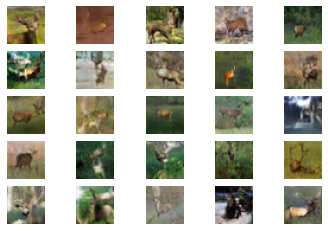

In [ ]:
# size of latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)